## Description

Необходимо помесячно предсказать объем продаж квартир в квадратных метрах на февраль, март, апрель 2018г. Предсказание делается для каждого сета - набора квартир из одного корпуса (id_bulk), с одинаковой комнатностью (spalen). 

Публичный рейтинг строится на основе 75% test-сета. Финальный рейтинг по 100% test-сета будет построен после завершения публичной части соревнования и появится в разделе «Результаты». Метрика оценки качества решения - RMSE.

- **train.csv**
Тренировочный датасет, в каждой строчке в поле value указан объем продаж в квадратных метрах в соответствующий месяц по соответствующему сету.
- **test.csv**
Тестовый датасет, предсказание необходимо сделать по каждому сету на февраль, март, апрель 2018г. По сравнению с train в test нет полей: start_square, plan_s, plan_m, plan_l, vid_0, vid_1, vid_2. Данные поля удалены т.к. могут быть некорректно использованы при расчет объема продаж в прошлом месяце в тестовом периоде.
- **flat.csv**
Параметры всех квартир, в поле sale указана дата продажи квартиры (кроме test периода), для непроданных квартир за train период в поле sale указан 01.01.2020г.
- **status.csv**
История изменения статусов по каждой квартире (кроме test периода). Информация о резервах может быть очень полезна для предсказания первого месяца тестового периода.
- **price.csv**
История изменения цены по каждой квартире (кроме test периода)

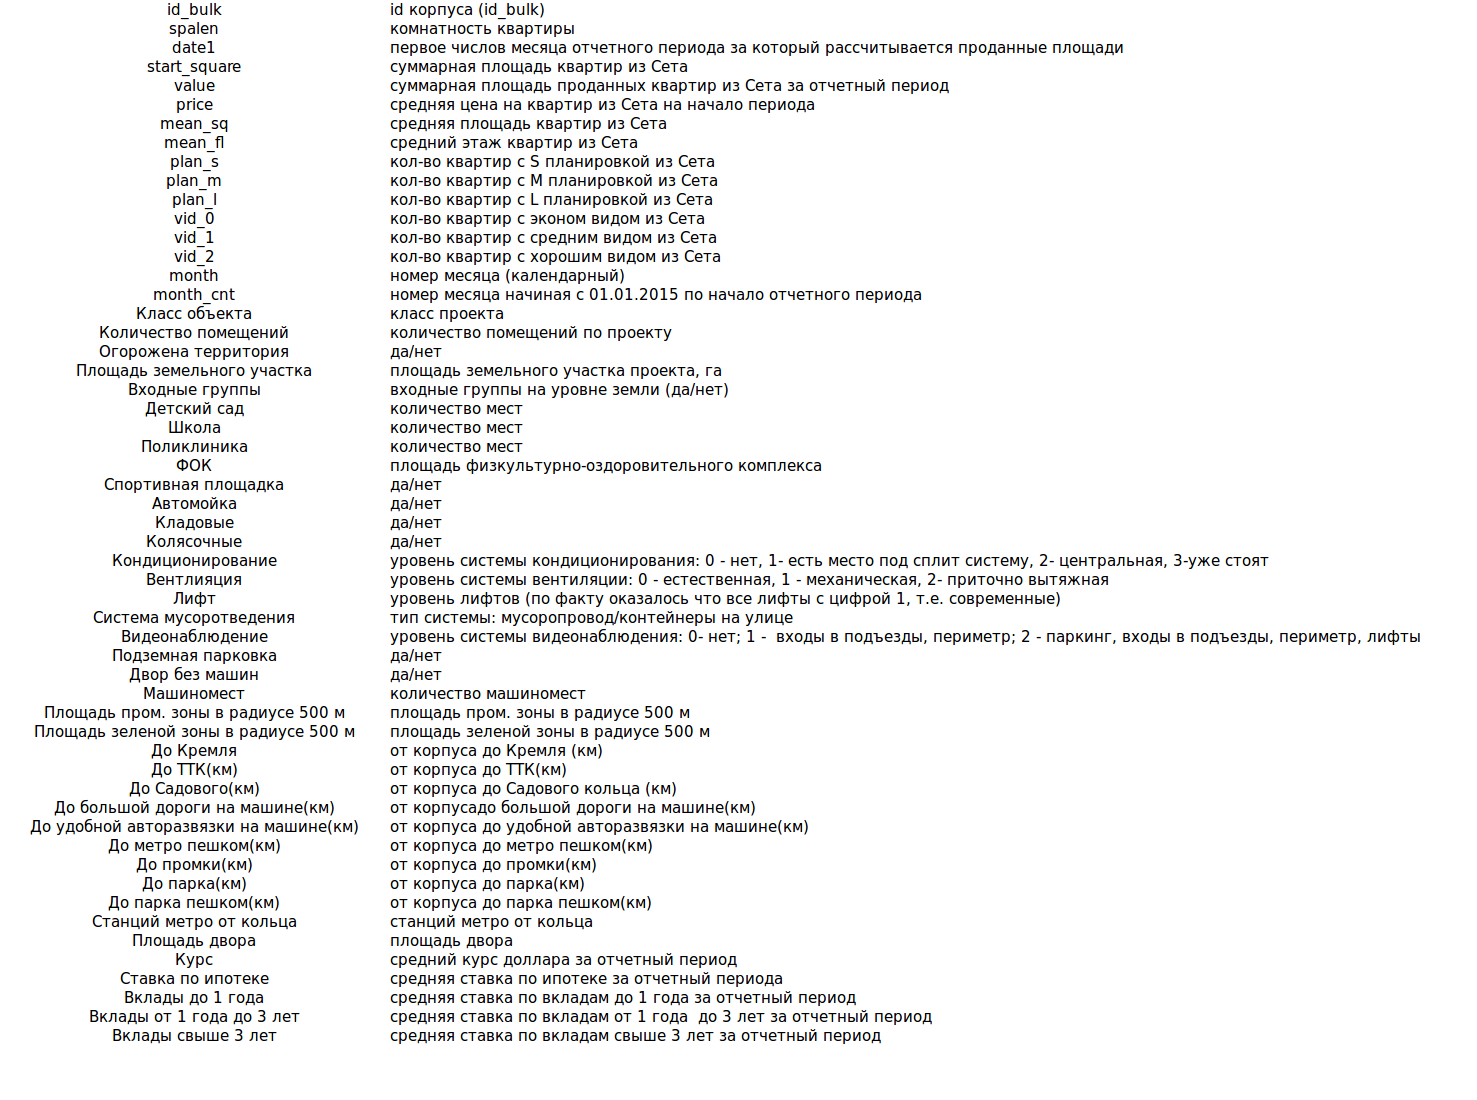

## Load

In [1]:
import pandas as pd, numpy as np

In [2]:
train = pd.read_csv('data/train.csv', index_col='id', encoding='cp1251')
test = pd.read_csv('data/test.csv', index_col='id', encoding='cp1251')

flat = pd.read_csv('data/flat.csv', encoding='cp1251')

In [3]:
flat.head().T

,0,1,2,3,4
id_sec,846EA675-93FF-E411-8098-001EC9D56418,846EA675-93FF-E411-8098-001EC9D56418,846EA675-93FF-E411-8098-001EC9D56418,846EA675-93FF-E411-8098-001EC9D56418,846EA675-93FF-E411-8098-001EC9D56418
floor,2,2,2,2,2
spalen,3,1,1,0,2
stage_number,1,2,3,4,5
square,85.9,34.2,33.7,22.4,57.5
balcon,0,0,0,0,0
otdelka,Не производится,Не производится,Не производится,Не производится,Не производится
plan0,3M-1*,1S-1*,1S-2*,S-1*,2M-1
id_bulk,4B3B6D6A-93FF-E411-8098-001EC9D56418,4B3B6D6A-93FF-E411-8098-001EC9D56418,4B3B6D6A-93FF-E411-8098-001EC9D56418,4B3B6D6A-93FF-E411-8098-001EC9D56418,4B3B6D6A-93FF-E411-8098-001EC9D56418
section,1,1,1,1,1


- section - номер секции в корпусе (от 1 до где-то 12), sec_id - уникальный ид секции
- stage_number Номер на этаже

In [4]:
train.head().T

id,0,1,2,3,4
bulk_id,FF3814A9-9F7D-E711-8530-00505688958B,FF3814A9-9F7D-E711-8530-00505688958B,FF3814A9-9F7D-E711-8530-00505688958B,FF3814A9-9F7D-E711-8530-00505688958B,FF3814A9-9F7D-E711-8530-00505688958B
spalen,1,2,0,3,1
date1,2017-10-01,2017-10-01,2017-10-01,2017-10-01,2017-11-01
start_square,13109.9,19898.4,2100,9614.9,11947.2
value,1124.5,1412.3,345,769.4,526.7
price,135634,128492,158238,123250,139421
mean_sq,38,58.01,22.58,78.81,37.93
mean_fl,8,9,10,8,9
plan_s,147,139,78,50,140
plan_m,198,120,15,0,175


In [5]:
test.head().T

id,0,1,2,3,4
bulk_id,FF3814A9-9F7D-E711-8530-00505688958B,FF3814A9-9F7D-E711-8530-00505688958B,FF3814A9-9F7D-E711-8530-00505688958B,FF3814A9-9F7D-E711-8530-00505688958B,FF3814A9-9F7D-E711-8530-00505688958B
spalen,1,2,0,3,1
date1,2018-02-01,2018-02-01,2018-02-01,2018-02-01,2018-03-01
price,144734,136730,167788,132855,147387
mean_sq,37.97,57.78,23.21,79.39,37.99
mean_fl,9,9,10,9,9
month,2,2,2,2,3
month_cnt,38,38,38,38,39
Класс объекта,эконом,эконом,эконом,эконом,эконом
Количество помещений,1983,1983,1983,1983,1983


In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

## Feature preparation

### Date split

In [7]:
import time
from tqdm._tqdm_notebook import tqdm_notebook

import urllib.request as ur  

In [8]:
def holidays(d, m, year):
    time.sleep(0.2)
    elevations = ur.urlopen("https://kayaposoft.com/enrico/json/v2.0/?action=isPublicHoliday&date="+str(d)+'-'+str(m)+'-'+str(year)+"&country=ru").read()
    data = json.loads(elevations)
    if data['isPublicHoliday'] == True:
        return 1
    else:
        return 0

def extr(df, date_column):
    df.at[df[pd.isnull(df[date_column])].index, date_column] = '2017-02-01'
    
    tmp = pd.DataFrame(list(zip(df[date_column].unique(), [holidays(d.split('-')[2], d.split('-')[1], d.split('-')[0]) for d in tqdm_notebook(df[date_column].unique())])), 
                       columns=['date', 'value'])
    
    df['holiday'] = df[date_column].apply(lambda x: tmp.loc[tmp['date'] == x,'value'].values[0])
    df['tm_year'] = df[date_column].apply(lambda x: time.strptime(str(x), '%Y-%m-%d')[0])
    #df['tm_mon'] = df[date_column].apply(lambda x:  time.strptime(str(x), '%Y-%m-%d')[1])
    #df['tm_mday'] = df[date_column].apply(lambda x: time.strptime(str(x), '%Y-%m-%d')[2])
    df['tm_wday'] = df[date_column].apply(lambda x: time.strptime(str(x), '%Y-%m-%d')[6])
    df['tm_yday'] = df[date_column].apply(lambda x: time.strptime(str(x), '%Y-%m-%d')[7])
    return df

In [9]:
train = extr(train, 'date1')
test = extr(test, 'date1')

In [10]:
dop_cat_cols = ['spalen', 'month', 'Спортивная площадка', 'Кондиционирование', 
                'Вентлияция', 'Видеонаблюдение', 'holiday', 'tm_year', 'tm_mon', 'tm_mday','tm_wday']
drop_colm = ['Лифт', 'Система мусоротведения']

train.drop(drop_colm, axis=1, inplace=True)
test.drop(drop_colm, axis=1, inplace=True)

TODO сколько дней до праздника

## EDA

### Plot duplicates

In [11]:
def plot_duplicatesplot_dup (df):
    df = df.dropna(axis=1, thresh = 10)
    result = {col:df.duplicated([col]).sum() for col in df.columns}
    plt.figure(figsize=(4,10))
    plt.barh(list(result.keys()), list(result.values()), color='g', alpha=0.5)
    plt.show()

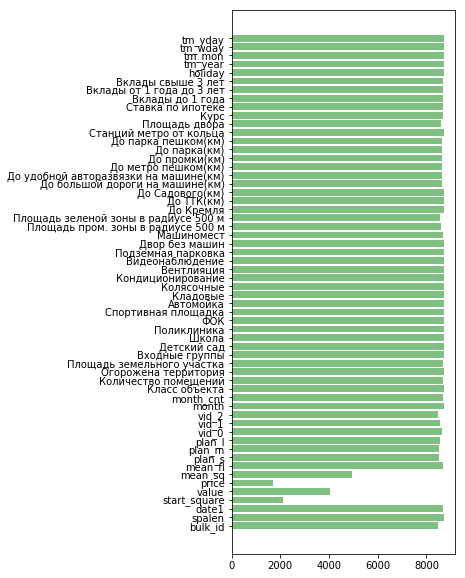

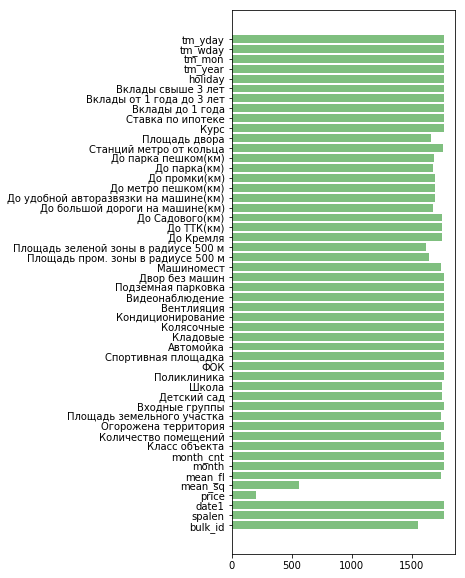

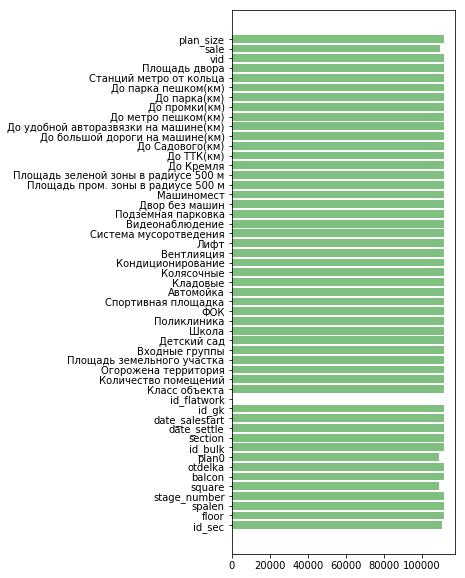

In [27]:
plot_duplicatesplot_dup(train)
plot_duplicatesplot_dup(test)
plot_duplicatesplot_dup(flat)   

### Value count

In [13]:
def val_count(df):
    for col in df.columns:
        print(df[col].value_counts(normalize=True).head(10), 'Len: ', df[col].value_counts(normalize=True).shape,'\n')

In [14]:
val_count(train)

8B5D0C0E-C378-E511-B4A4-001EC9D5643C    0.015013
E435277C-002B-E511-82D8-001EC9D5643C    0.013752
D04F1379-5729-E511-84C6-001EC9D56418    0.013294
59BCC6D3-7204-E511-8C7F-001EC9D5643C    0.012950
67A58823-AFC9-E511-9405-001EC9D56418    0.012721
8B240E6D-7FCA-E511-9405-001EC9D56418    0.012606
8421806C-5D3E-E411-988B-001EC9D5643C    0.010887
C78A74B1-07DD-E411-9A07-001EC9D56418    0.010772
4B3B6D6A-93FF-E411-8098-001EC9D56418    0.010658
B526E7C2-5C3E-E411-988B-001EC9D5643C    0.010429
Name: bulk_id, dtype: float64 Len:  (233,) 

1    0.274238
2    0.258538
3    0.234242
0    0.169608
4    0.063374
Name: spalen, dtype: float64 Len:  (5,) 

2017-11-01    0.067958
2017-12-01    0.067156
2018-01-01    0.063832
2017-09-01    0.061311
2017-10-01    0.061196
2017-08-01    0.056269
2017-07-01    0.054779
2017-06-01    0.054091
2017-05-01    0.046871
2017-04-01    0.043204
Name: date1, dtype: float64 Len:  (31,) 

87.50      0.003323
45.40      0.003209
44.18      0.003094
22.40      0.002063
1

In [15]:
val_count(test)

49A66B38-9682-E711-8530-00505688958B    0.008475
A0B7B63B-6DAF-E711-8547-00505688958B    0.008475
999F708D-4FE9-E711-B9FF-00505688958B    0.008475
460B6880-F8BE-E711-BC64-00505688958B    0.008475
43FD321D-7304-E511-8C7F-001EC9D5643C    0.008475
6FFE2FFC-94C4-E711-A992-0050568859FB    0.008475
E806378B-4566-E711-97EC-001EC9D56418    0.008475
EEA80383-6E98-E711-8530-00505688958B    0.008475
9A2B12C5-4566-E711-97EC-001EC9D56418    0.008475
B94A67F6-6498-E711-8530-00505688958B    0.008475
Name: bulk_id, dtype: float64 Len:  (215,) 

1    0.271751
2    0.266102
3    0.240113
0    0.146328
4    0.075706
Name: spalen, dtype: float64 Len:  (5,) 

2018-04-01    0.349718
2018-03-01    0.330508
2018-02-01    0.319774
Name: date1, dtype: float64 Len:  (3,) 

92000.0     0.004520
99000.0     0.003390
105000.0    0.003390
91000.0     0.003390
98000.0     0.003390
85000.0     0.002825
89000.0     0.002825
95500.0     0.002260
113000.0    0.002260
91800.0     0.002260
Name: price, dtype: float64 Len: 

In [28]:
val_count(flat)

A8A4DCAD-0CE0-E611-B887-001EC9D5643C    600
A2EEC933-EBAD-E611-9FBE-001EC9D5643C    600
43EB1D17-5003-E711-96FE-001EC9D5643C    390
4542F9D7-16F9-E611-84D2-001EC9D56418    384
BB80389C-16F9-E611-84D2-001EC9D56418    384
02ECC933-EBAD-E611-9FBE-001EC9D5643C    357
BC580706-506D-E711-97EC-001EC9D56418    354
4E0A4DE0-CE5A-E511-9A1C-001EC9D5643C    348
9F71ECFB-5034-E511-83C5-001EC9D5643C    348
E2A90040-8ABC-E611-B887-001EC9D5643C    348
093F1E87-F683-E711-8530-00505688958B    320
CC100E72-9237-E611-9447-001EC9D56418    319
18951E04-CF5A-E511-9A1C-001EC9D5643C    319
08ECC933-EBAD-E611-9FBE-001EC9D5643C    315
1C7D3012-CA05-E811-893D-00505688958B    307
Name: id_sec, dtype: int64
Column val_count id_sec shape: (1172,)
4     6773
3     6755
7     6742
5     6728
6     6718
8     6685
2     6653
9     6619
10    5880
11    5689
12    5505
13    5221
14    5113
15    4664
16    3979
Name: floor, dtype: int64
Column val_count floor shape: (33,)
2.0    41735
1.0    38477
3.0    18386
0.0    1

2020-01-01 00:00:00    33012
2012-10-04 20:00:00      801
2017-10-24 21:00:00      344
2017-11-14 21:00:00      304
2017-11-29 21:00:00      293
2017-10-30 21:00:00      276
2011-01-18 20:00:00      268
2017-03-30 21:00:00      211
2017-06-29 21:00:00      201
2017-09-29 21:00:00      197
2017-11-28 21:00:00      187
2017-09-28 21:00:00      184
2016-10-23 21:00:00      178
2017-07-30 21:00:00      176
2017-03-24 21:00:00      175
Name: sale, dtype: int64
Column val_count sale shape: (2218,)
M     40148
L     35536
S     34742
-1     1160
Name: plan_size, dtype: int64
Column val_count plan_size shape: (4,)


### Unique numbers

In [16]:
train.nunique(dropna=False)

bulk_id                                   233
spalen                                      5
date1                                      31
start_square                             6607
value                                    4676
price                                    7025
mean_sq                                  3792
mean_fl                                    32
plan_s                                    201
plan_m                                    196
plan_l                                    185
vid_0                                     105
vid_1                                     186
vid_2                                     243
month                                      12
month_cnt                                  31
Класс объекта                               3
Количество помещений                       29
Огорожена территория                        2
Площадь земельного участка                 29
Входные группы                              2
Детский сад                       

In [17]:
test.nunique(dropna=False)

bulk_id                                   215
spalen                                      5
date1                                       3
price                                    1569
mean_sq                                  1206
mean_fl                                    31
month                                       3
month_cnt                                   3
Класс объекта                               3
Количество помещений                       29
Огорожена территория                        2
Площадь земельного участка                 29
Входные группы                              2
Детский сад                                21
Школа                                      16
Поликлиника                                 4
ФОК                                         2
Спортивная площадка                         1
Автомойка                                   2
Кладовые                                    2
Колясочные                                  2
Кондиционирование                 

In [31]:
flat.nunique(dropna=False)

id_sec                                     1172
floor                                        33
spalen                                        5
stage_number                                 30
square                                     2897
balcon                                        2
otdelka                                      24
plan0                                      2938
id_bulk                                     271
section                                      17
date_settle                                 100
date_salestart                              178
id_gk                                        30
id_flatwork                              111586
Класс объекта                                 3
Количество помещений                         29
Огорожена территория                          2
Площадь земельного участка                   29
Входные группы                                2
Детский сад                                  21
Школа                                   

### Compare test and train

In [18]:
def comare_df(df1, df2):
    for col in df1.columns:
        if col in df2.columns:
            ind = df1[col].isin(df2[col]) & df2[col].isin(df1[col])
            print(col, sum(ind))

Предсказать для теста - start_square, plan_s, plan_m, plan_l, vid_0, vid_1, vid_2

Вот и лики подъехали

In [19]:
comare_df(train, test)

bulk_id 1196
spalen 1770
date1 0
price 45
mean_sq 262
mean_fl 1769
month 361
month_cnt 0
Класс объекта 1770
Количество помещений 1770
Огорожена территория 1770
Площадь земельного участка 1770
Входные группы 1770
Детский сад 1770
Школа 1770
Поликлиника 1770
ФОК 1770
Спортивная площадка 1770
Автомойка 1770
Кладовые 1770
Колясочные 1770
Кондиционирование 1770
Вентлияция 1770
Видеонаблюдение 1770
Подземная парковка 1770
Двор без машин 1770
Машиномест 1770
Площадь пром. зоны в радиусе 500 м 1484
Площадь зеленой зоны в радиусе 500 м 1342
До Кремля 1770
До ТТК(км) 1770
До Садового(км) 1750
До большой дороги на машине(км) 1472
До удобной авторазвязки на машине(км) 1679
До метро пешком(км) 1713
До промки(км) 1716
До парка(км) 1674
До парка пешком(км) 1662
Станций метро от кольца 1770
Площадь двора 1389
Курс 0
Cтавка по ипотеке 0
Вклады до 1 года 0
Вклады от 1 года до 3 лет 0
Вклады свыше 3 лет 0
holiday 1459
tm_year 74
tm_mon 361
tm_wday 445
tm_yday 287


### More complicate value count

In [20]:
def hist(data, name, col, count, dir_name, show):
    '''
    data - value counts Series
    name - additional name for your plot
    count - the shape of value counts
    dir_name - additional directory for plot
    show - plot show or not
    '''
    plt.close()
    plt.figure(figsize=(8,10))
    plt.barh(data.index, data.values, color='g', alpha=0.6)
    plt.xlabel('Count')
    plt.ylabel('Top 15 values of ' + str(count))
    plt.title(col)
    
    if dir_name != None:
        if dir_name not in os.listdir('plot'):
            os.mkdir('plot/' + dir_name+'/')
        plt.savefig('plot/' + dir_name+ '/' + name + "_test_" + col + ".png")
    else:
        plt.savefig('plot/' + name + "_test_" + col + ".png")

    if show == True:
        plt.show()
    else:
        plt.ioff()
        plt.close()

def val_count(df, m_plot = False, name = 'Test', dir_name = None, show = True):
    ''' 
    
    Vizualize count of top 15 values in each column of the inputed DataFrame.
    
    m_plot: bool([True, False]), show pd.Series value count for each column. Saving each plot;
    name: str(), additional name for plot (if m_plot = True);
    dir_name: str(), default(None), additional directory for your plots;
    show: bool([True, False]), show your plot in notebook
    
    '''
    
    for col in df.columns:
        if m_plot == False:
            print (df[col].value_counts().head(15))
            print ('Column val_count ' + str(col) + ' shape: ' + str(df[col].value_counts().shape))
        else:
            hist(df[col].value_counts().head(15), name, col, df[col].value_counts().shape[0], dir_name, show)
            plt.close()

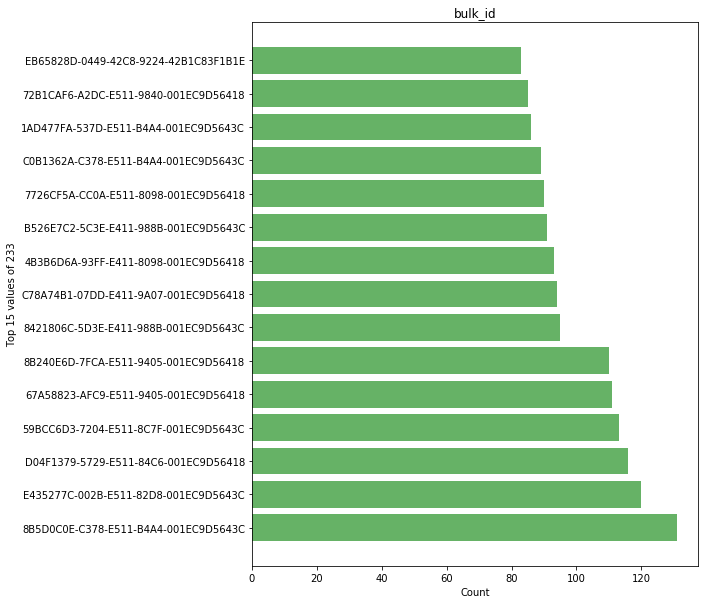

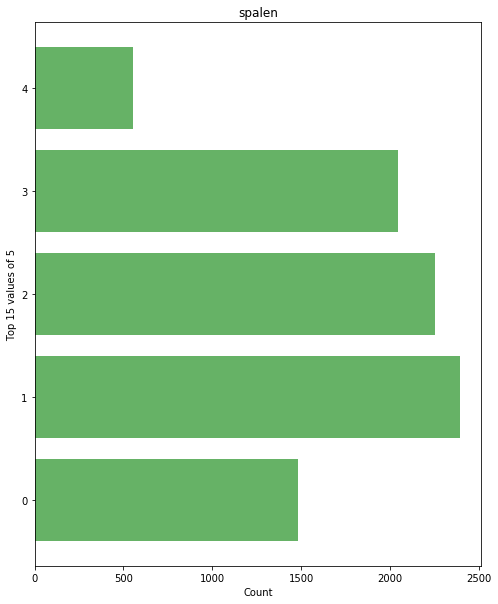

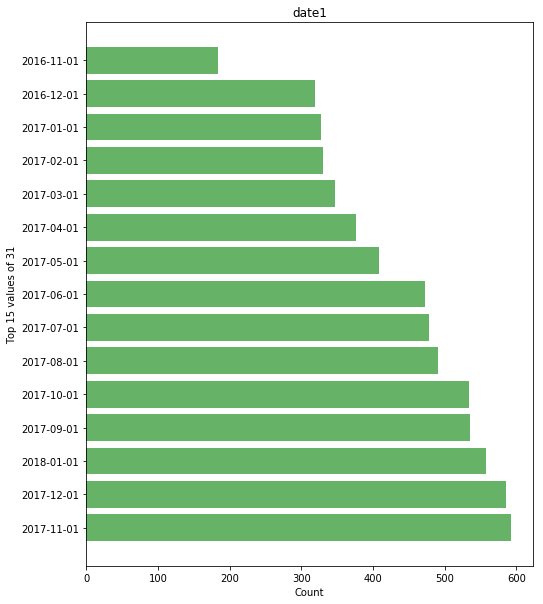

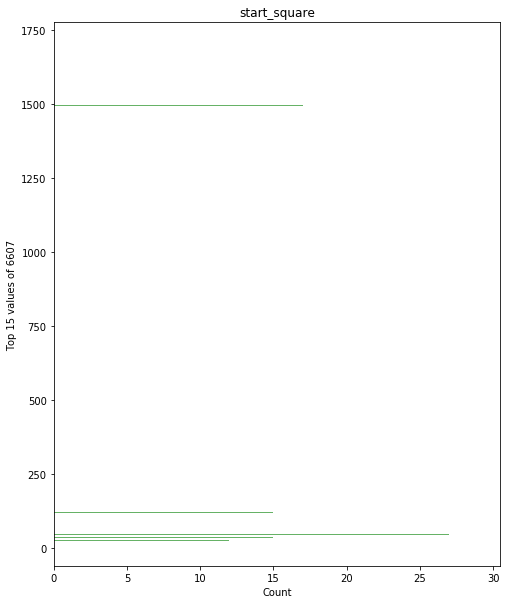

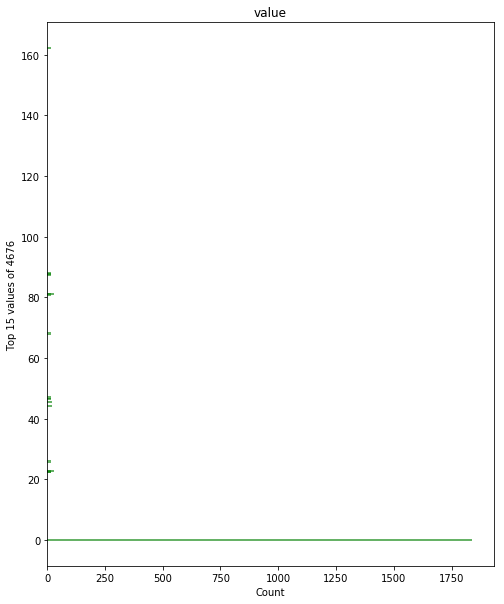

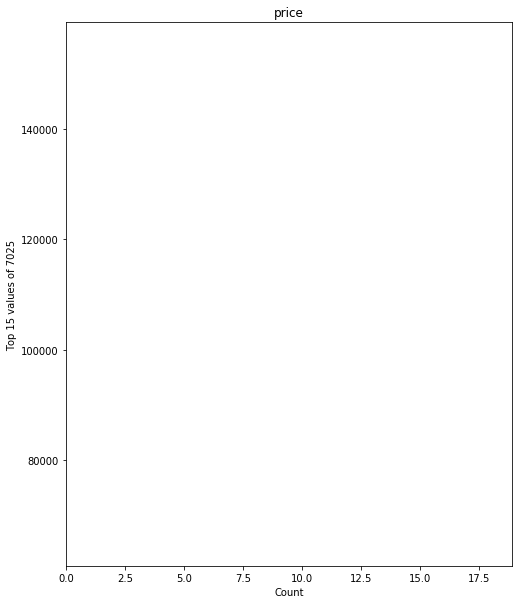

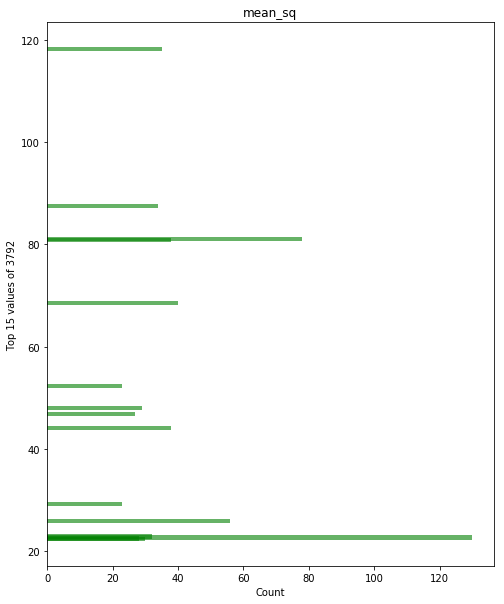

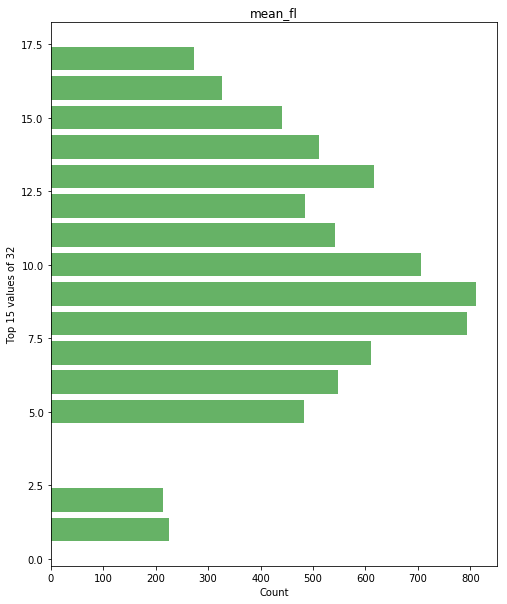

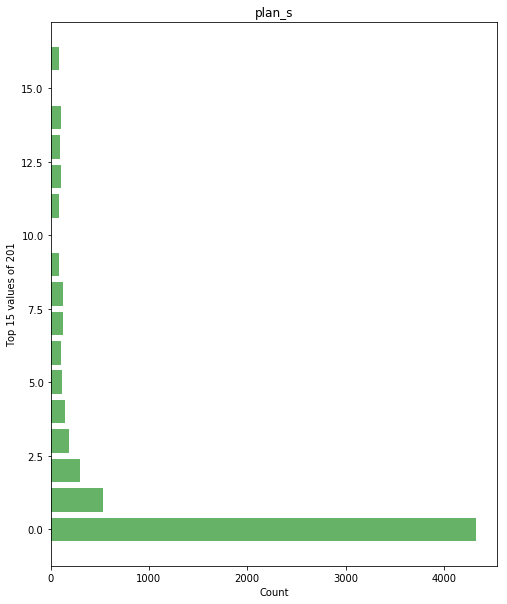

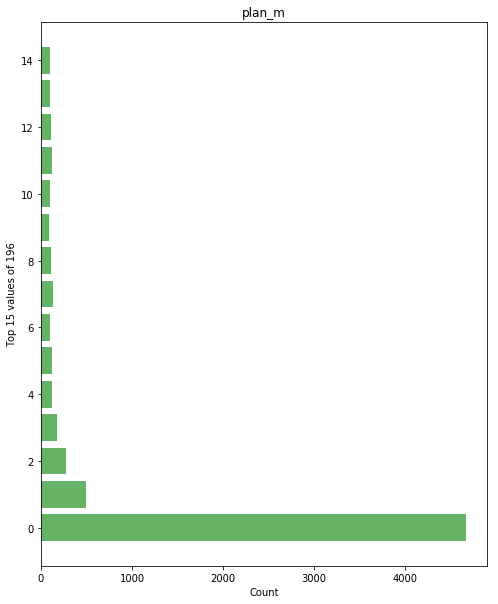

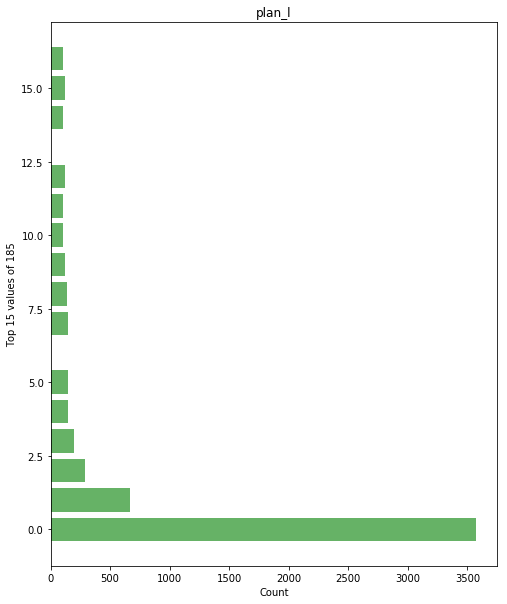

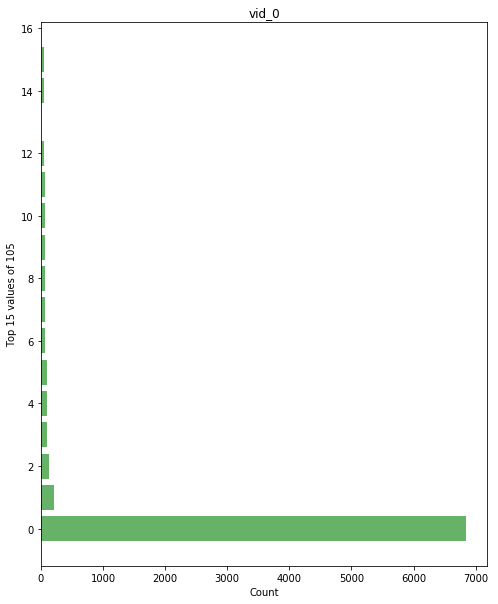

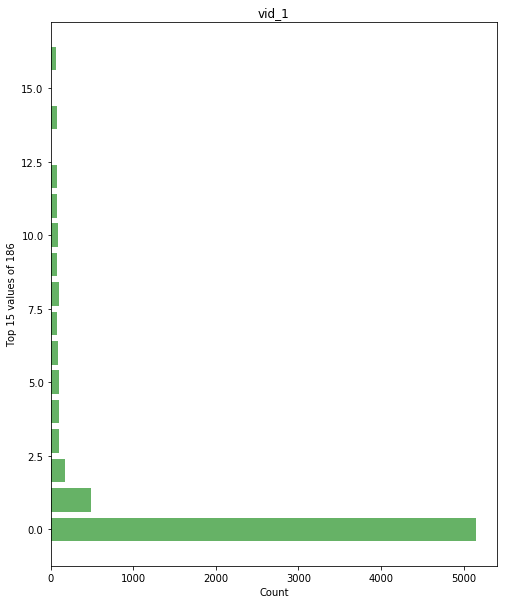

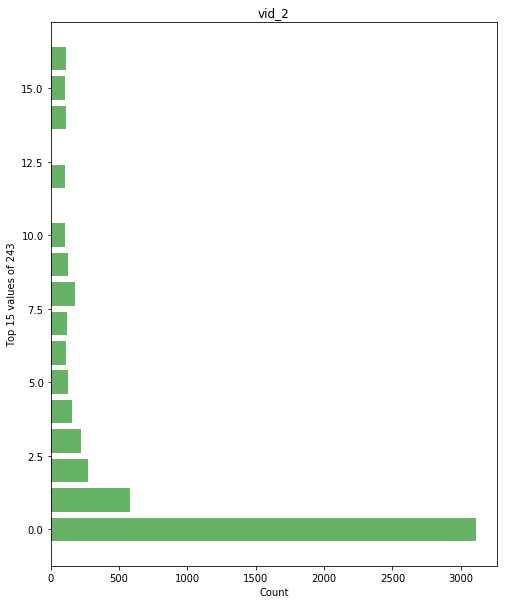

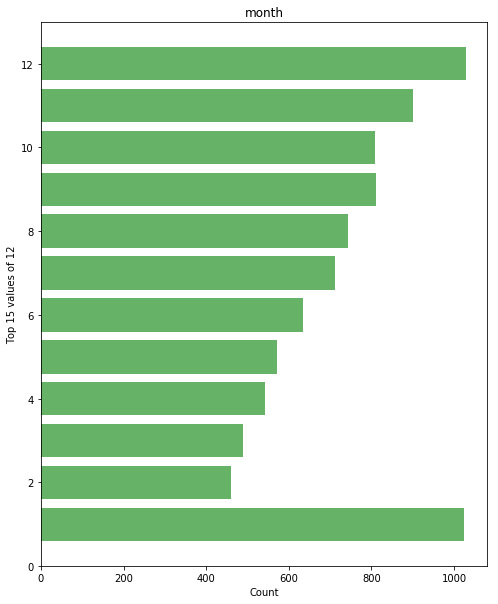

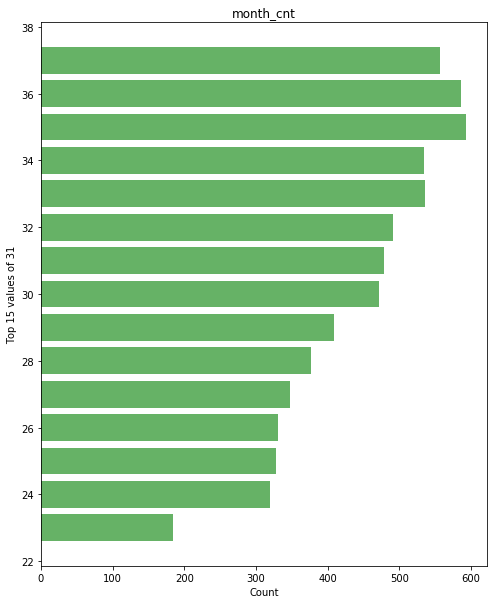

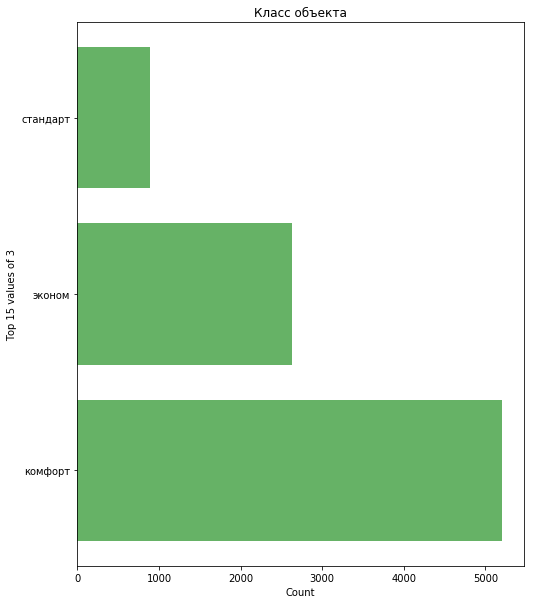

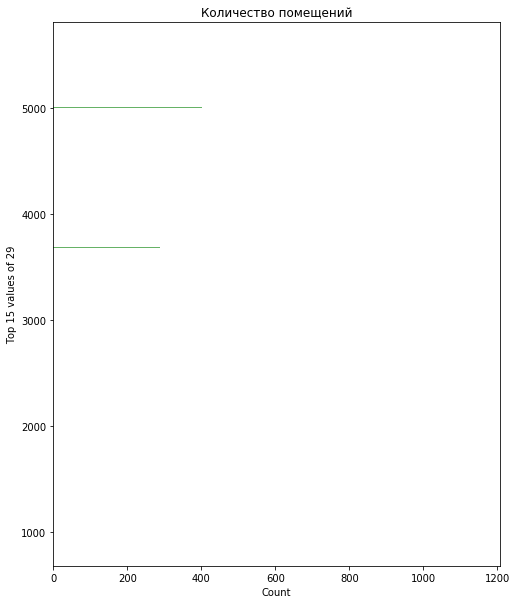

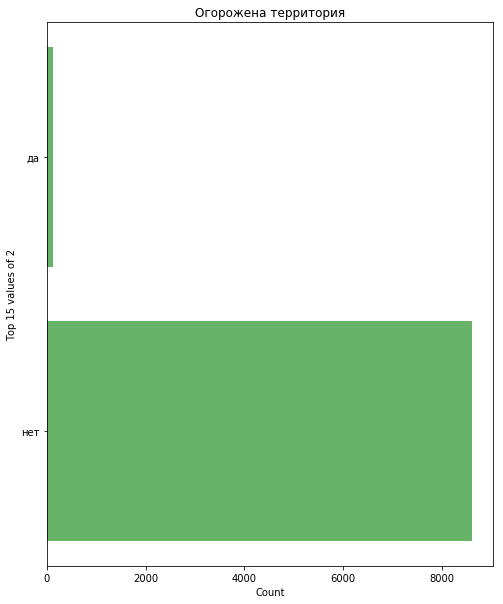

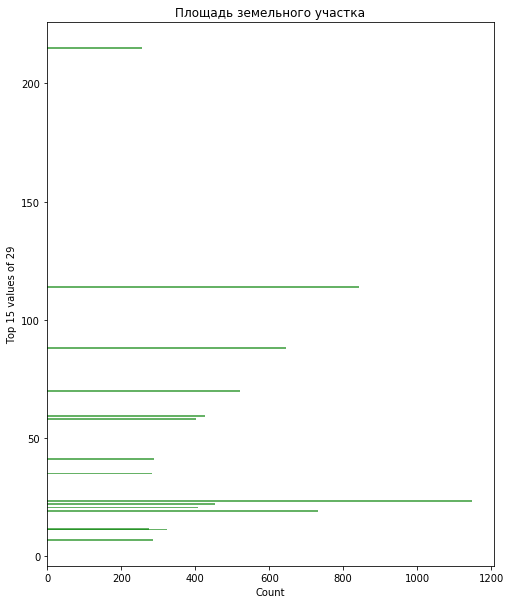

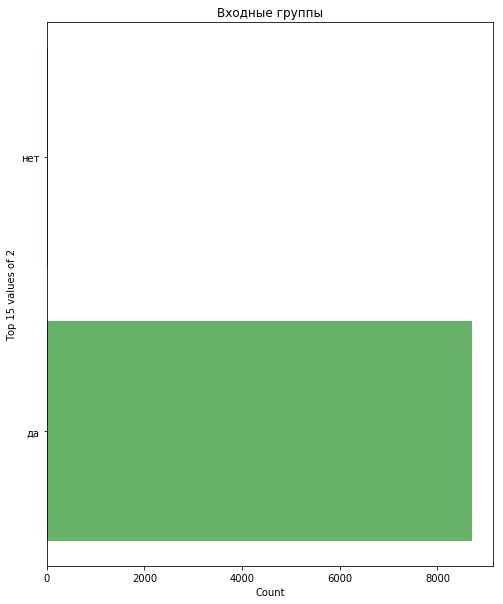

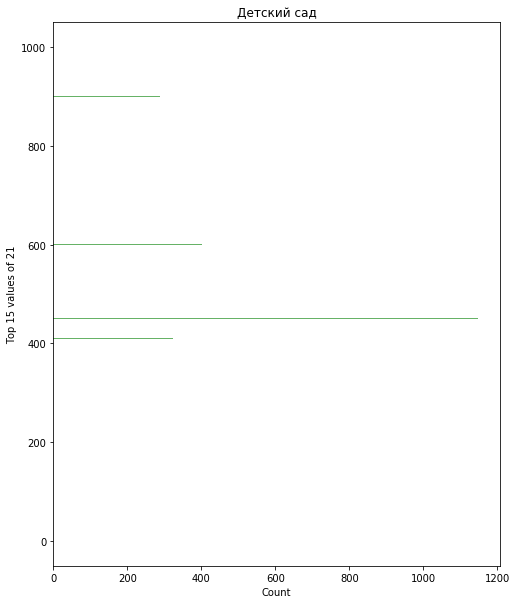

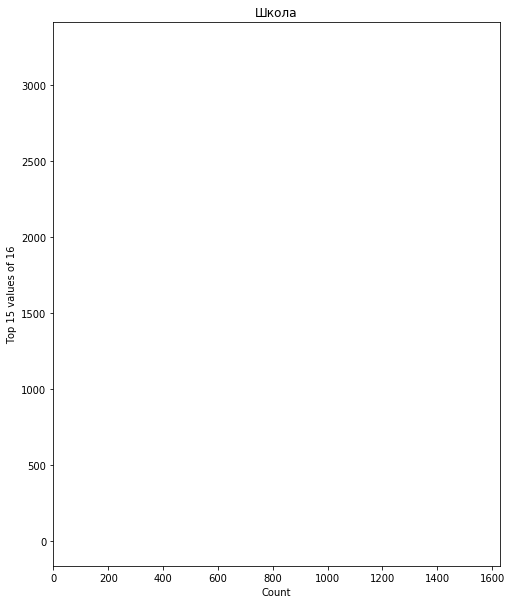

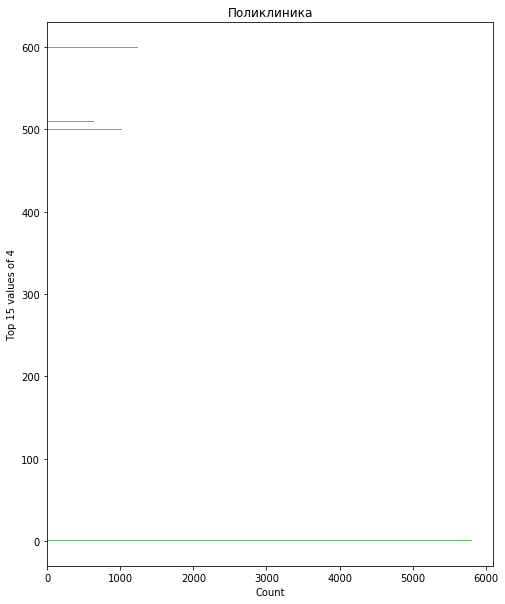

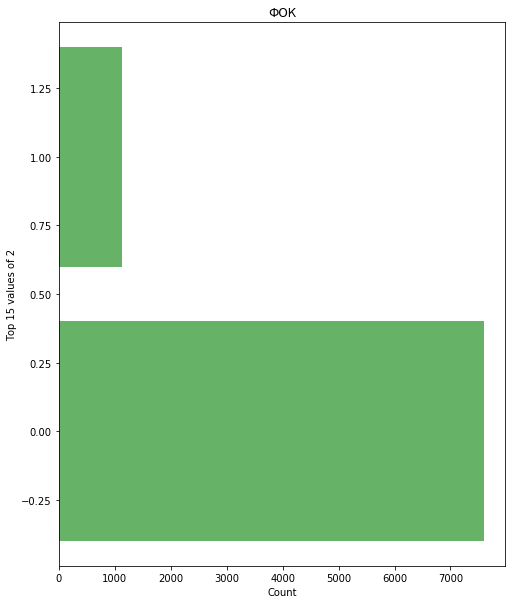

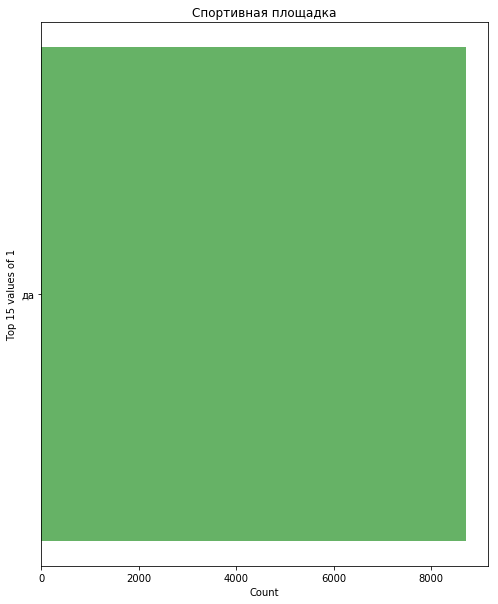

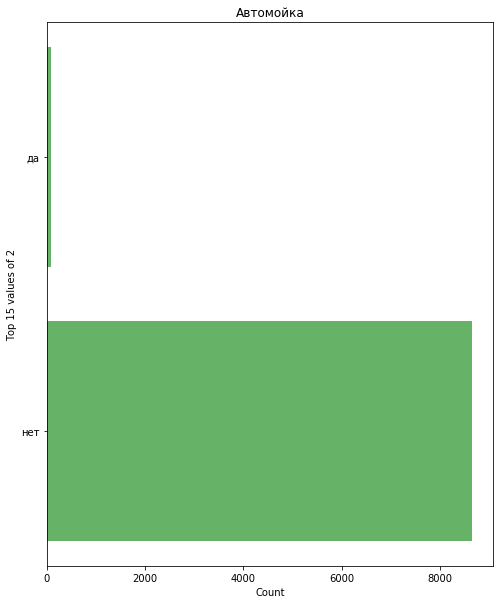

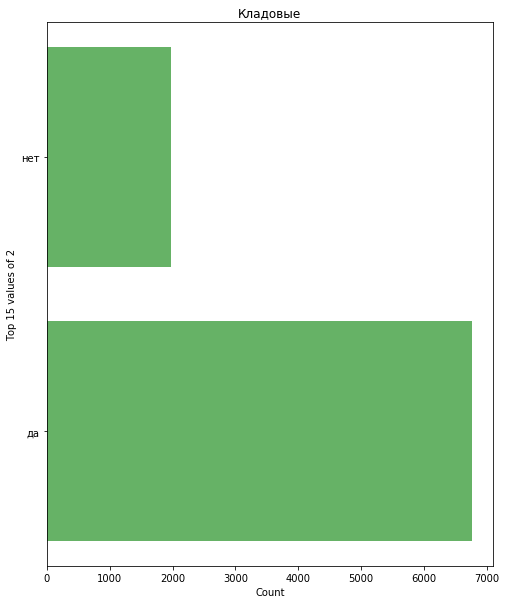

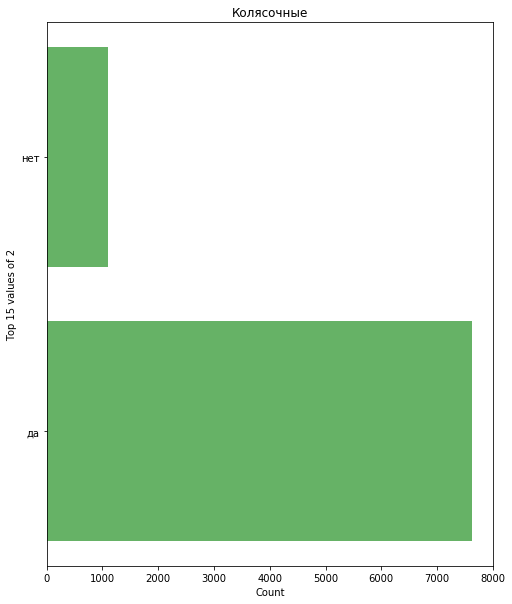

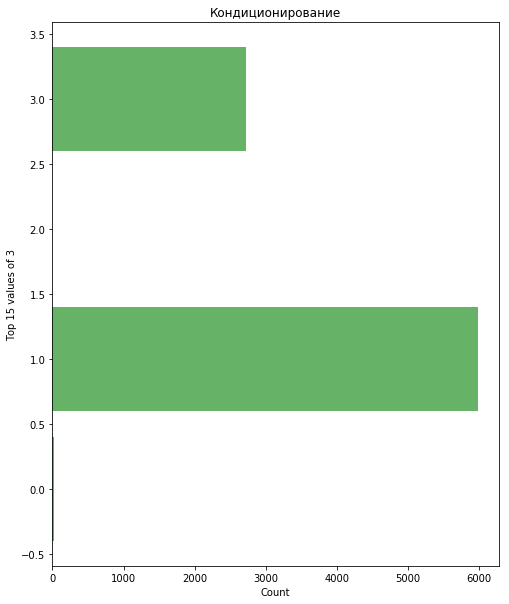

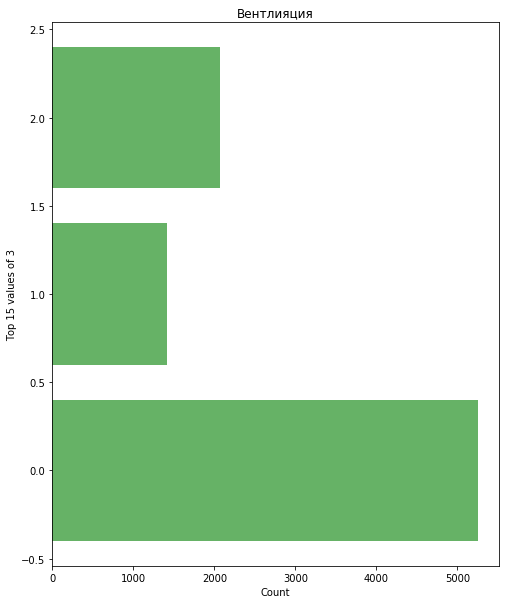

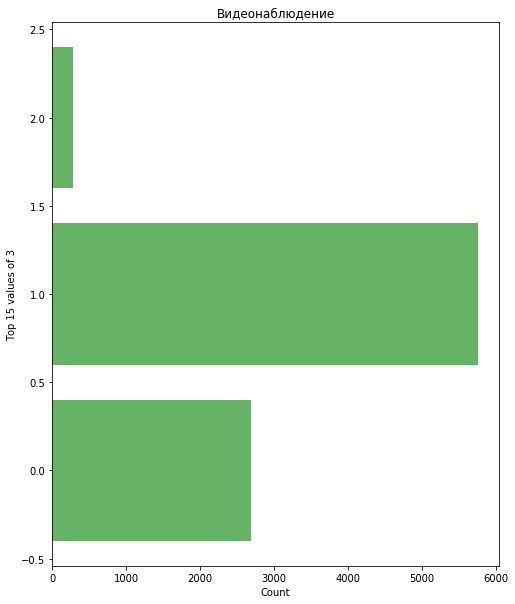

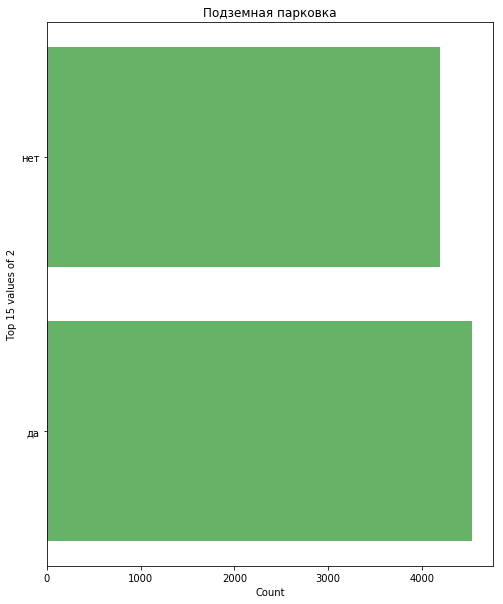

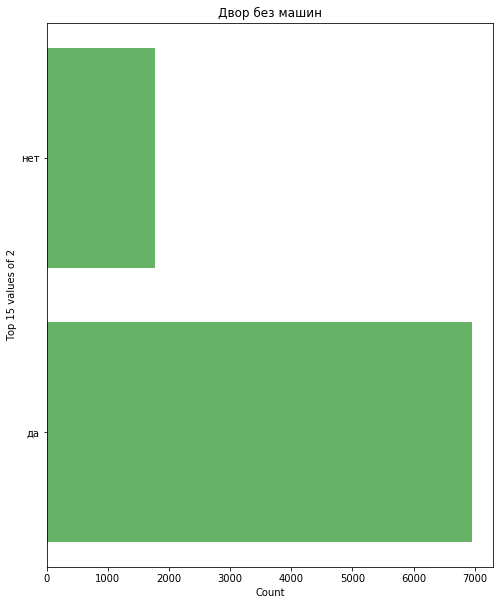

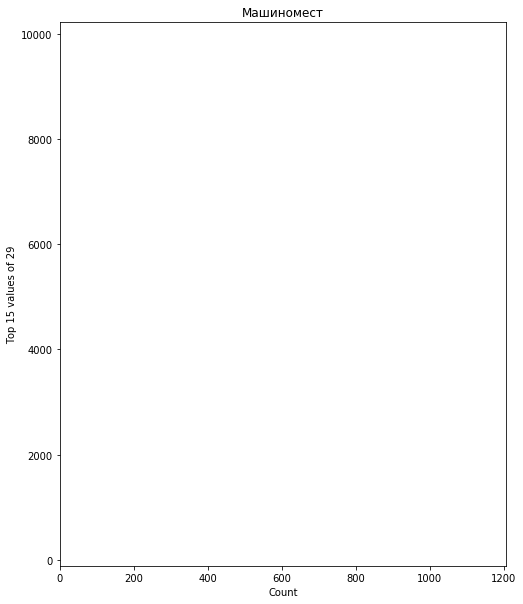

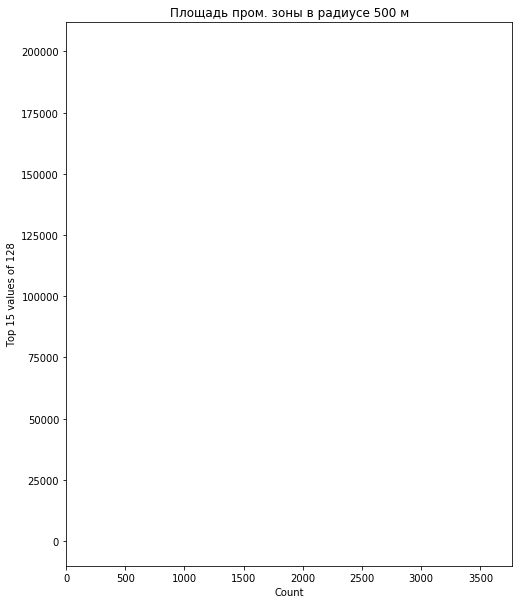

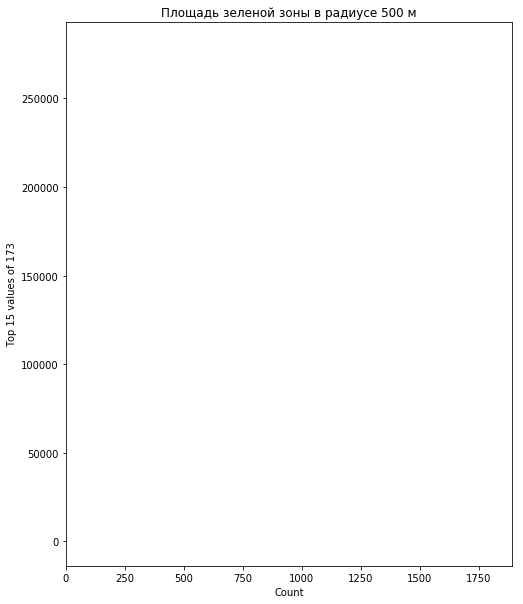

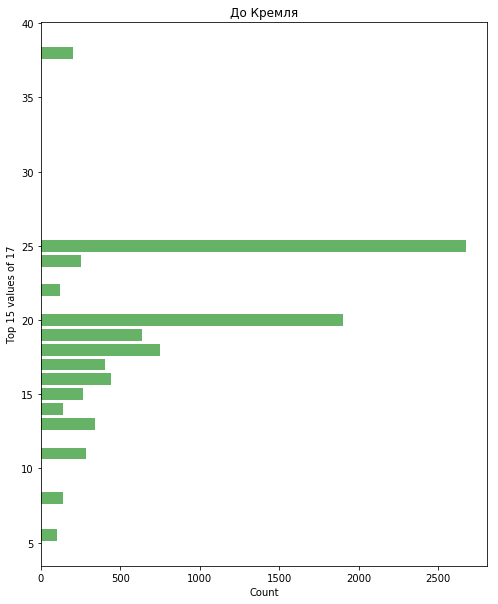

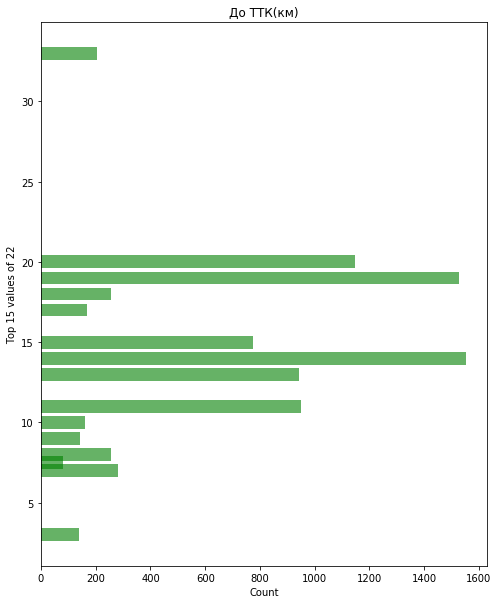

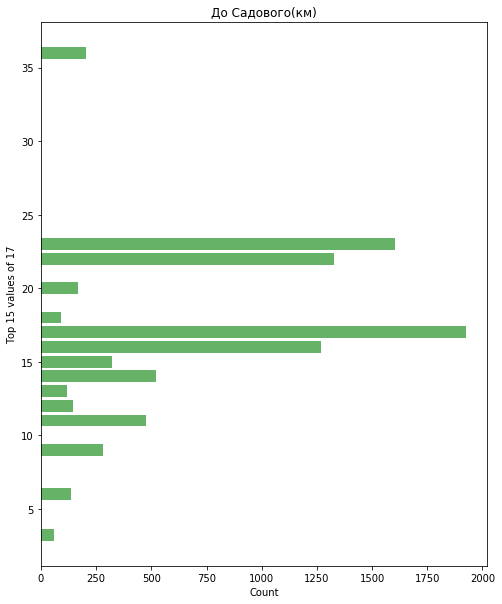

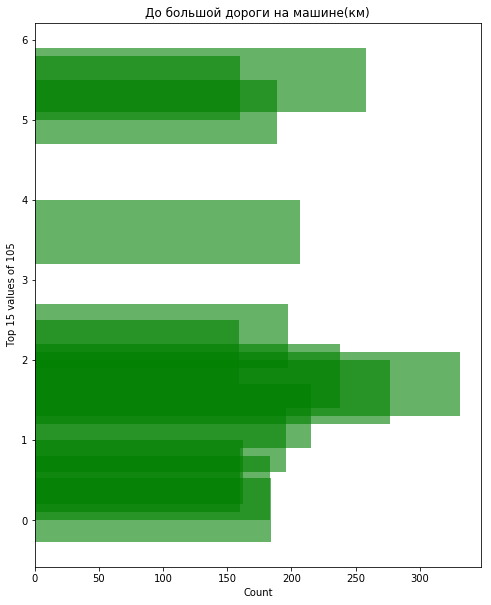

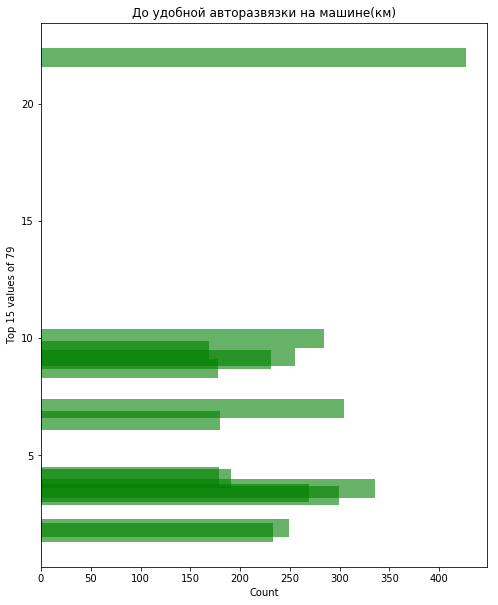

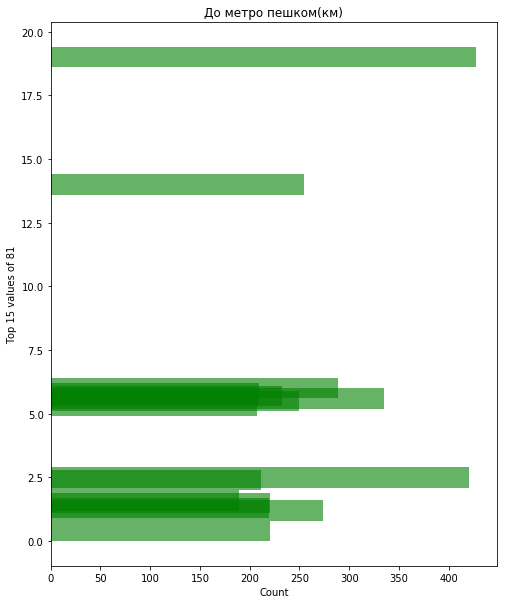

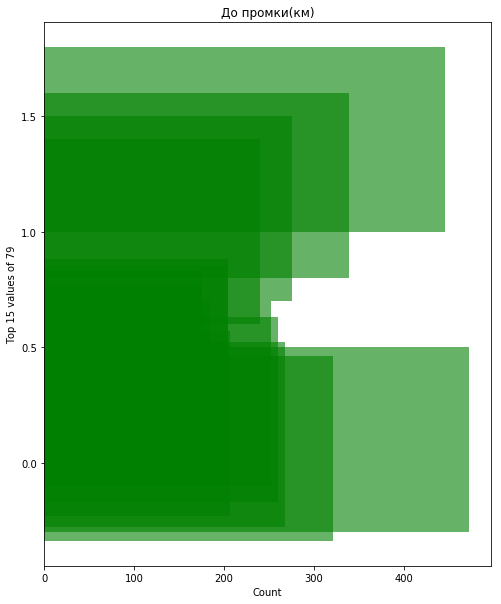

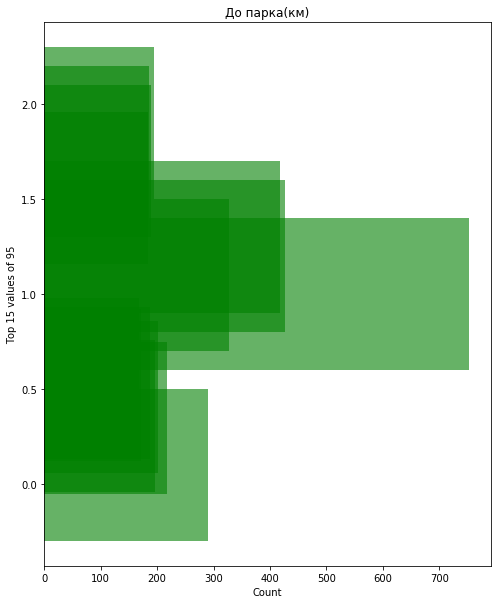

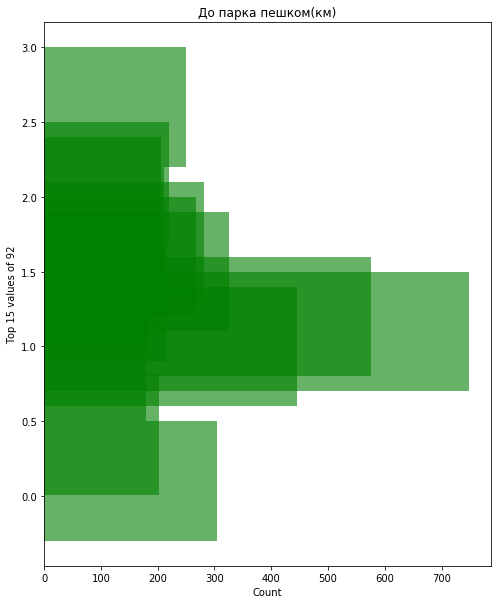

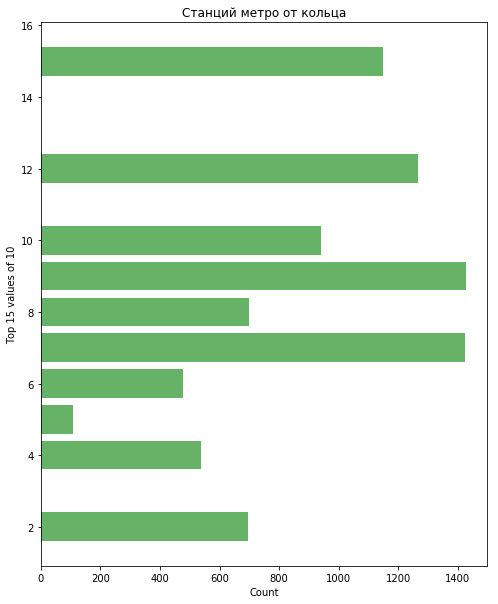

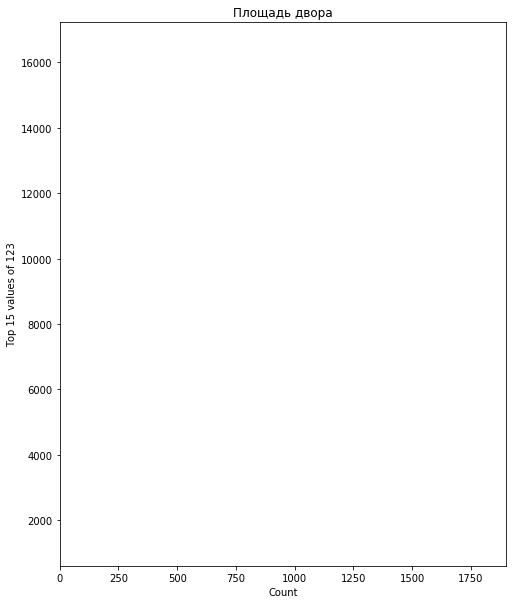

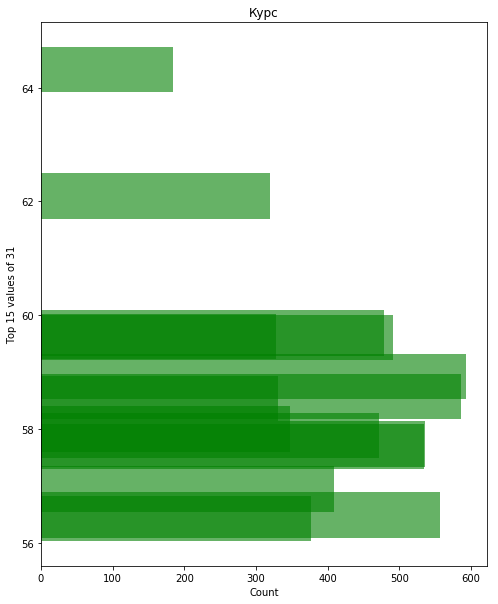

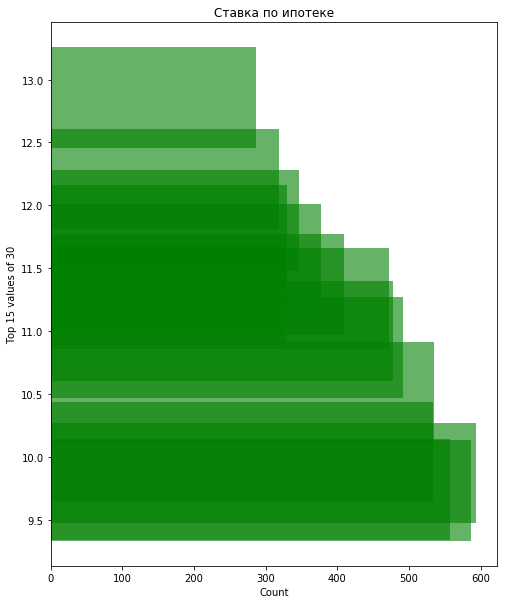

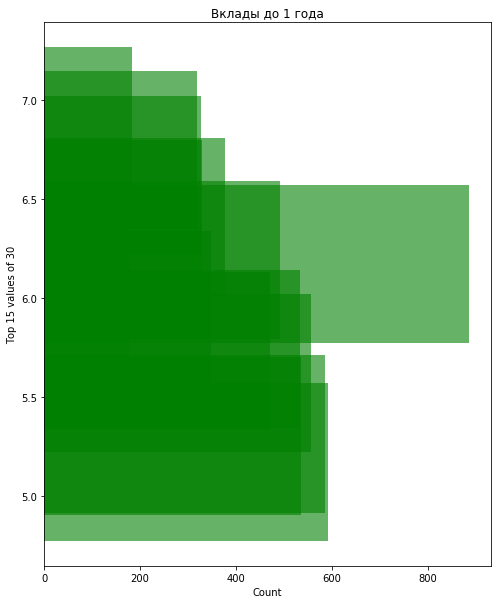

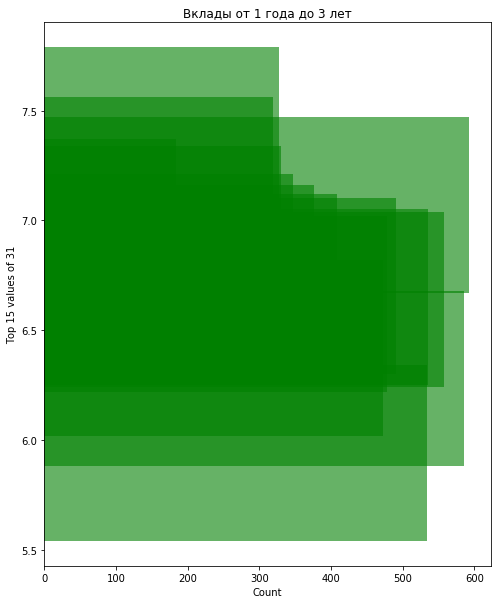

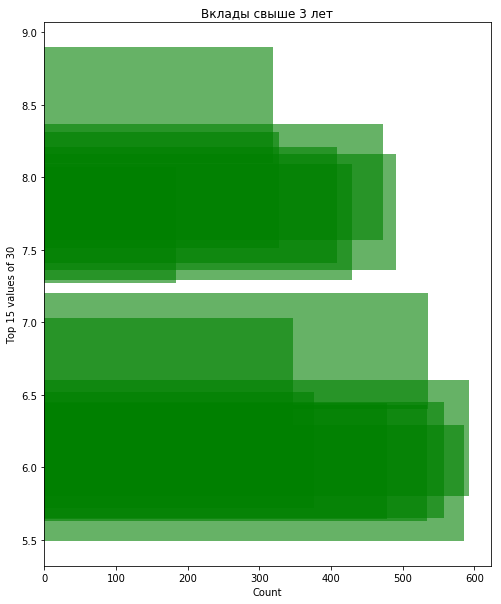

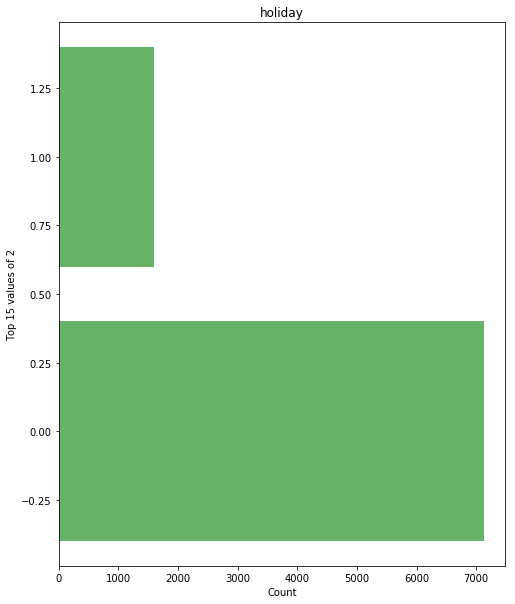

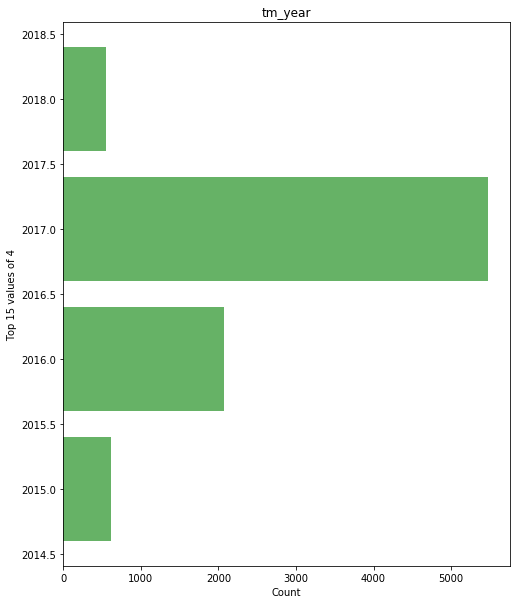

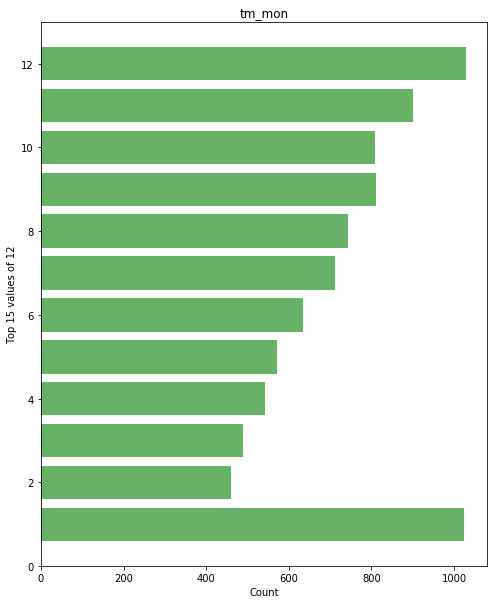

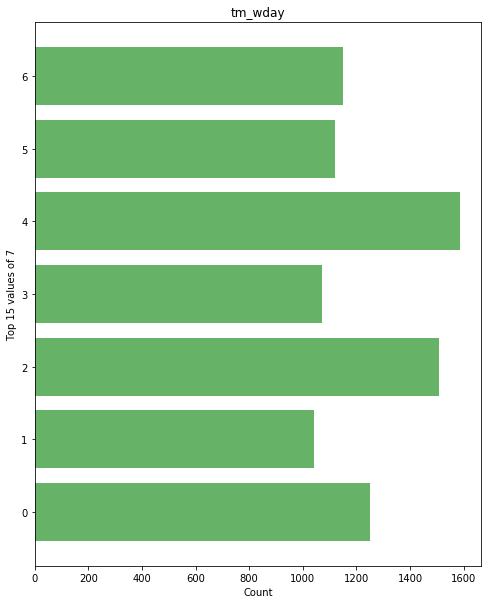

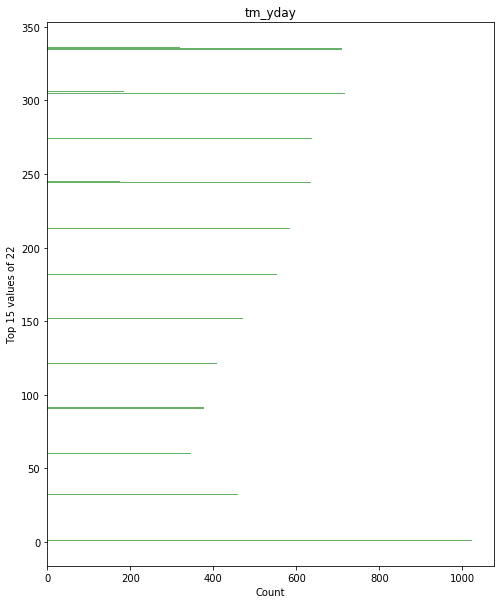

In [21]:
val_count(train, m_plot=True, name = 'Train')

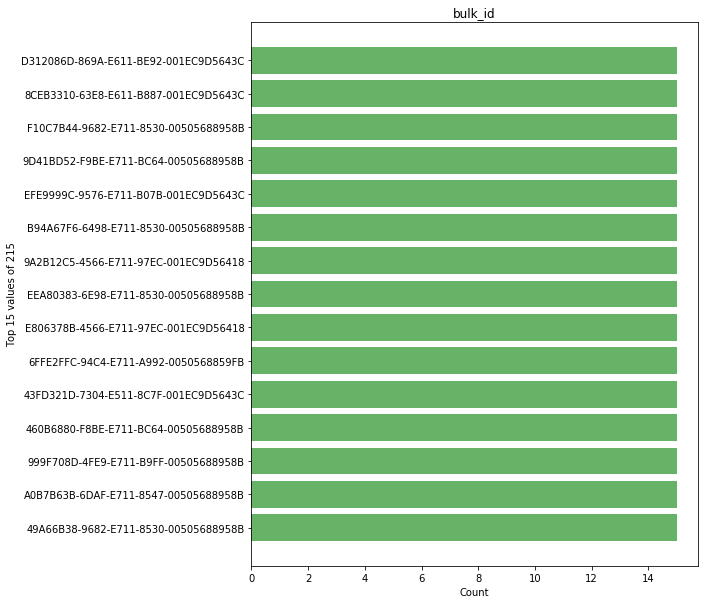

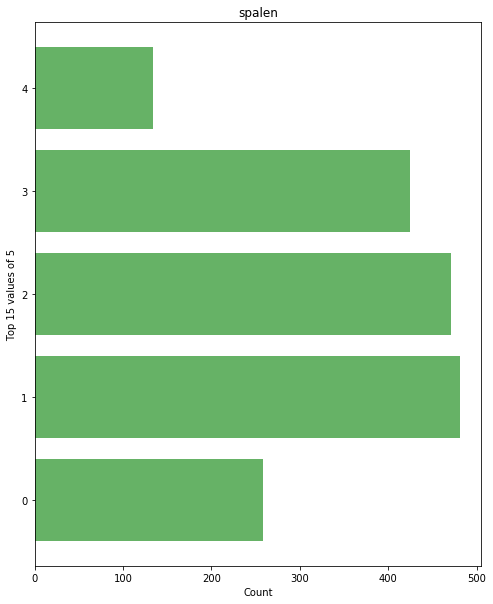

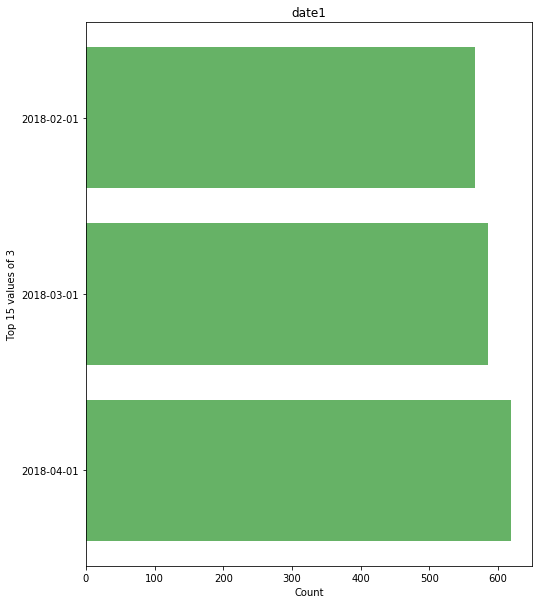

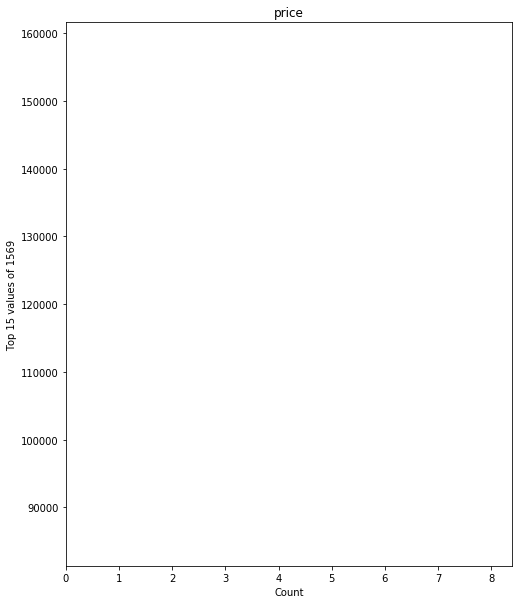

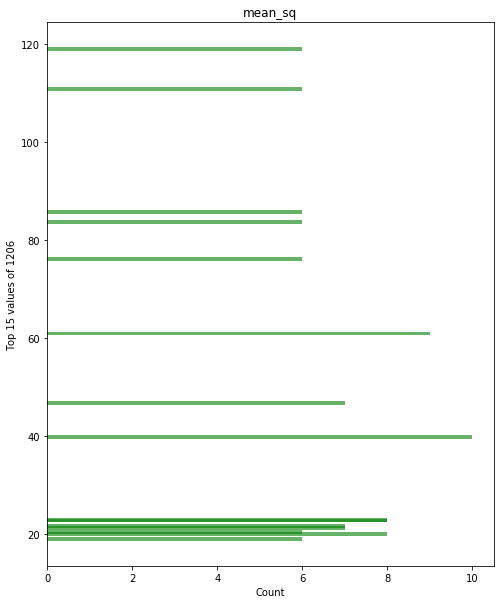

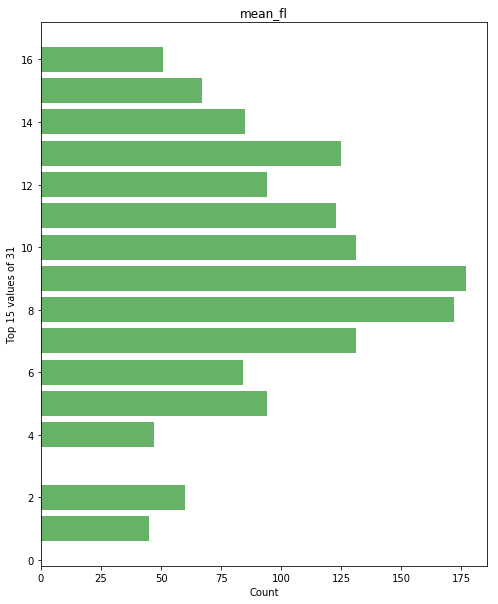

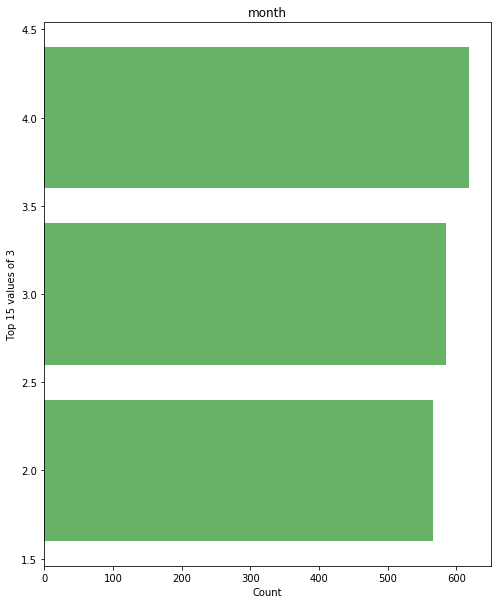

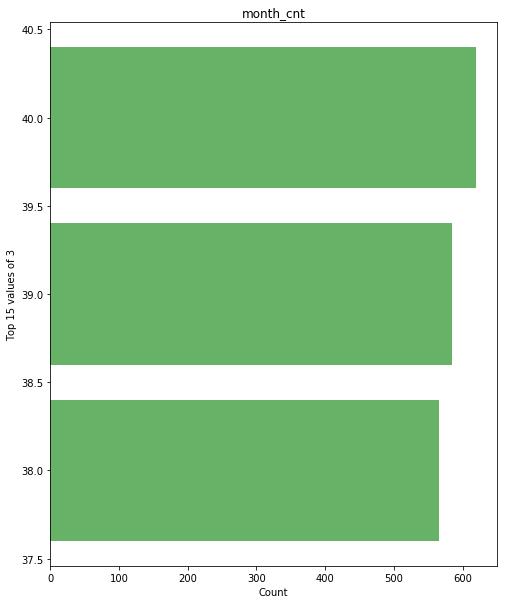

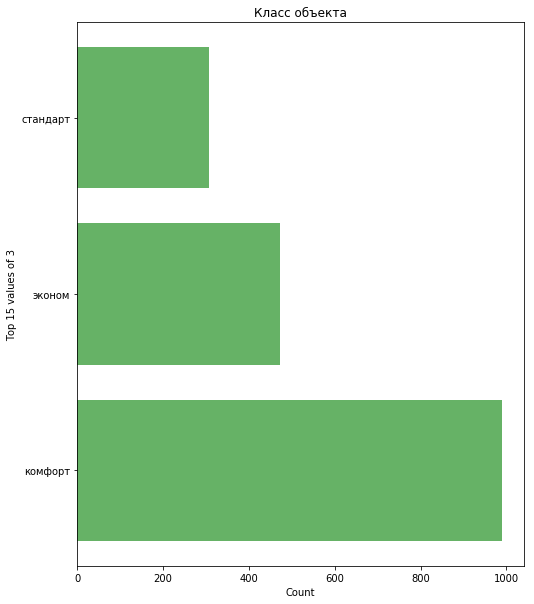

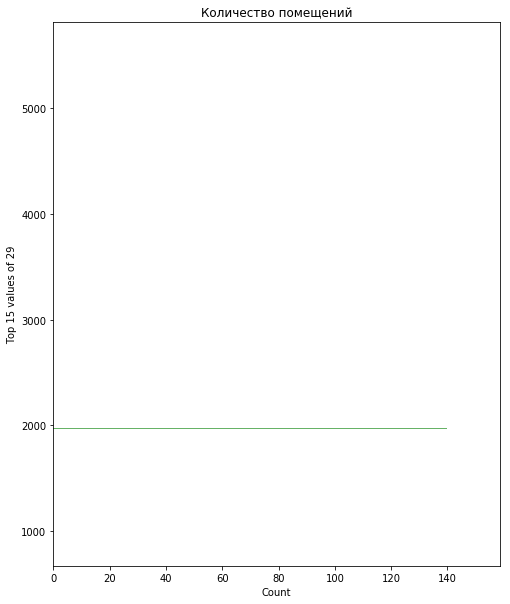

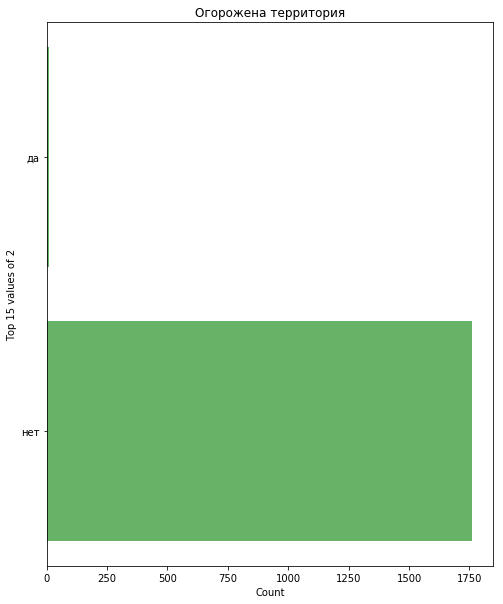

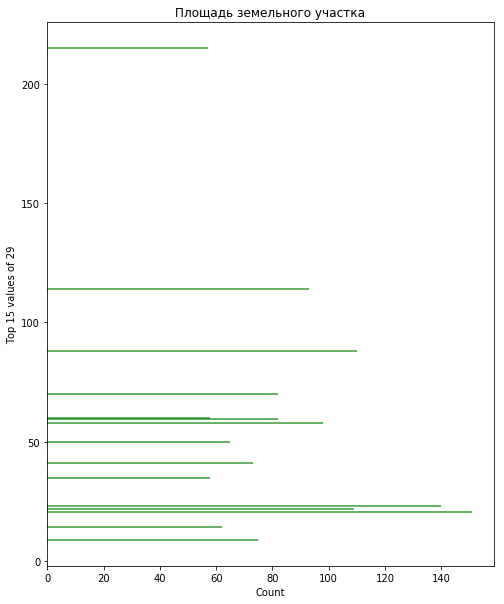

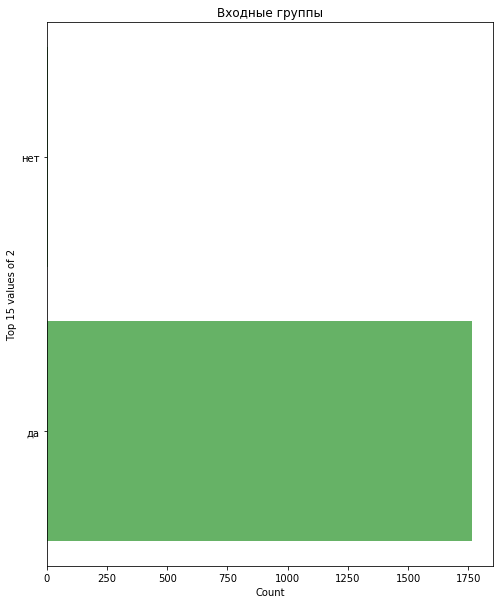

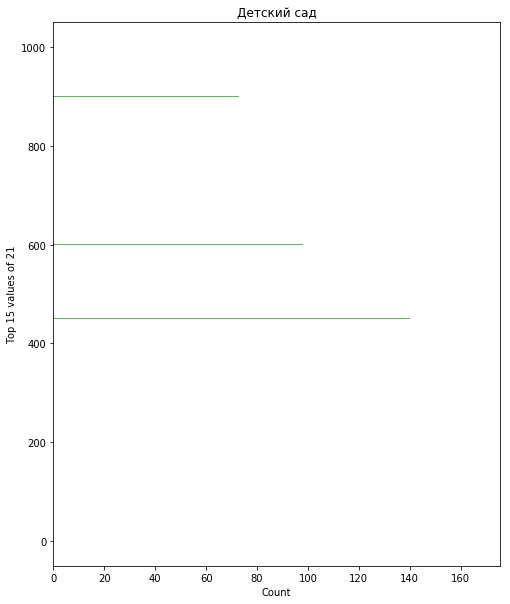

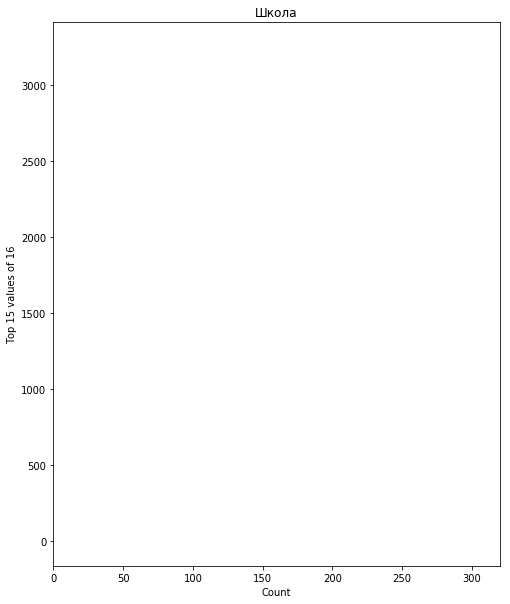

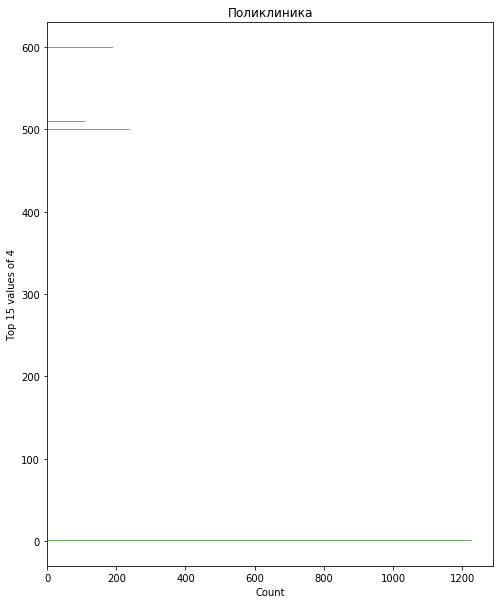

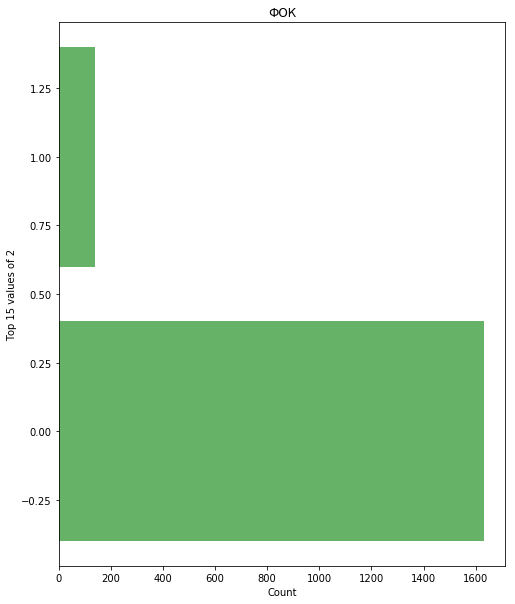

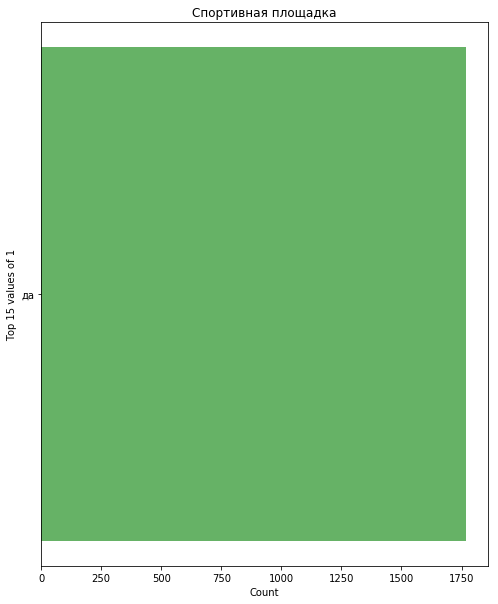

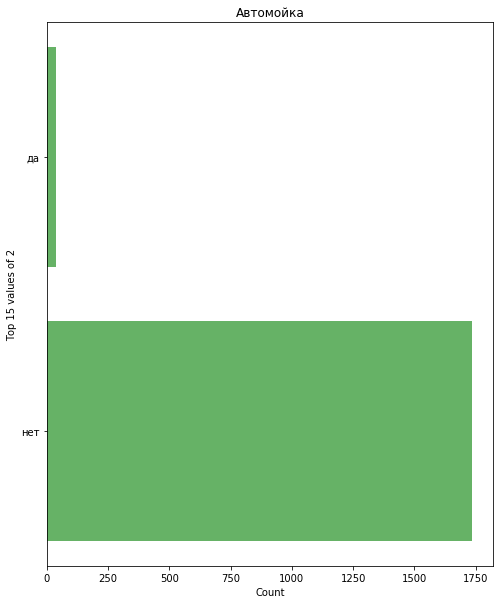

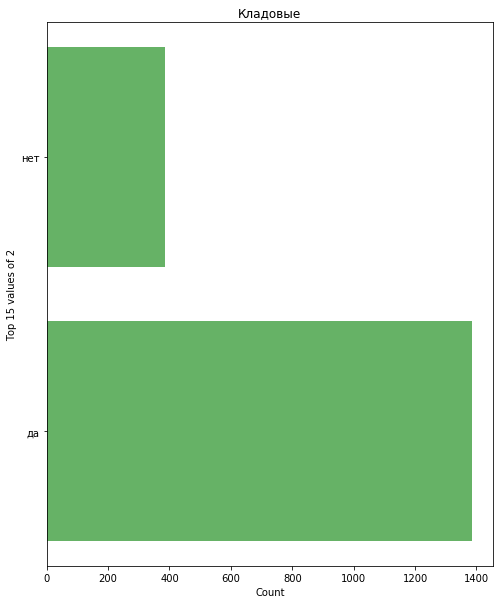

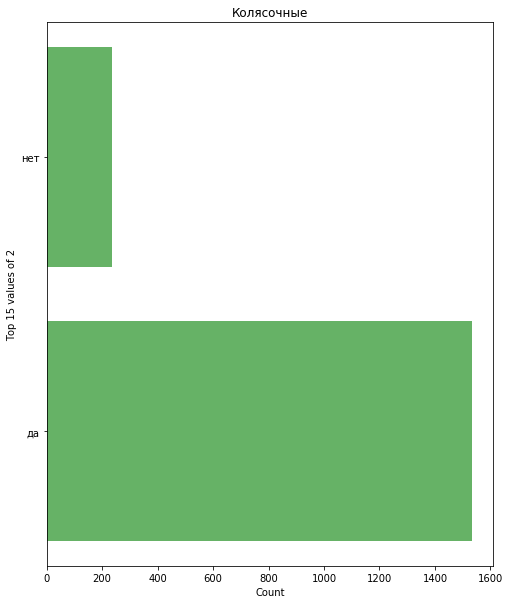

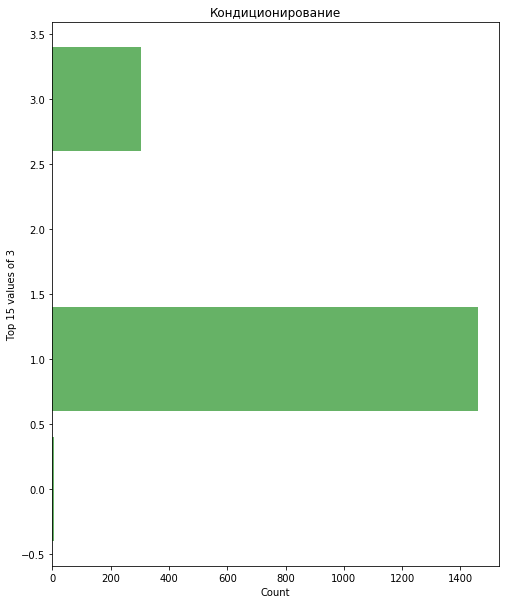

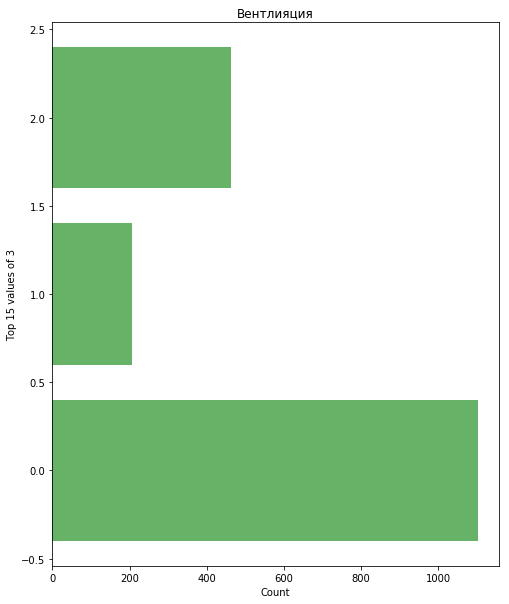

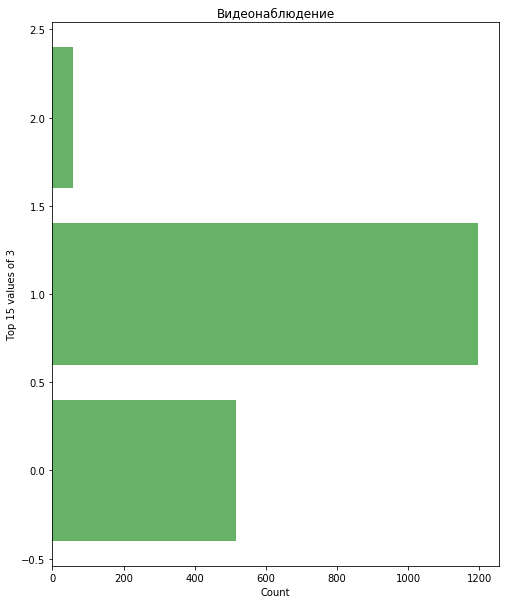

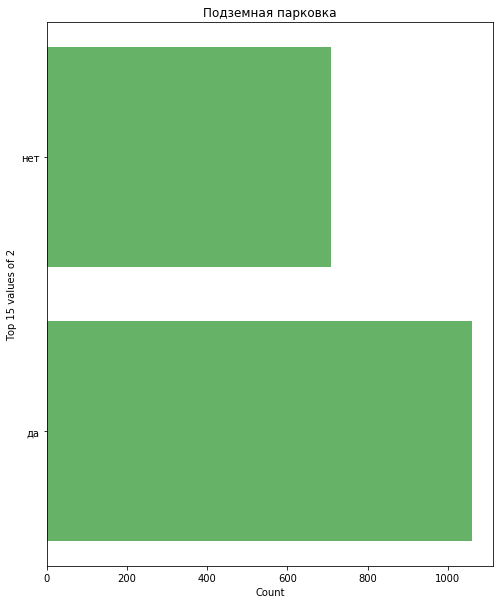

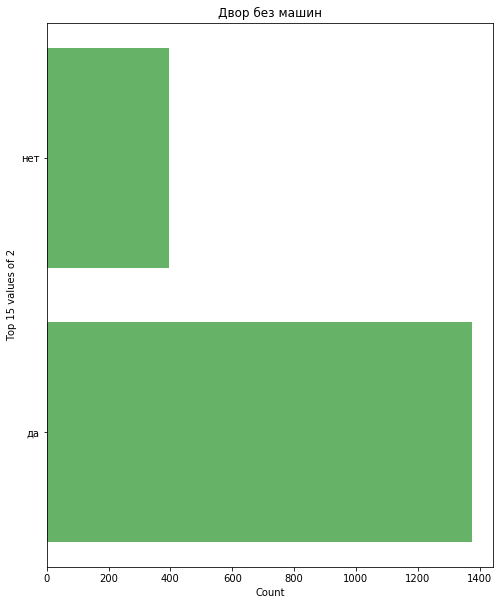

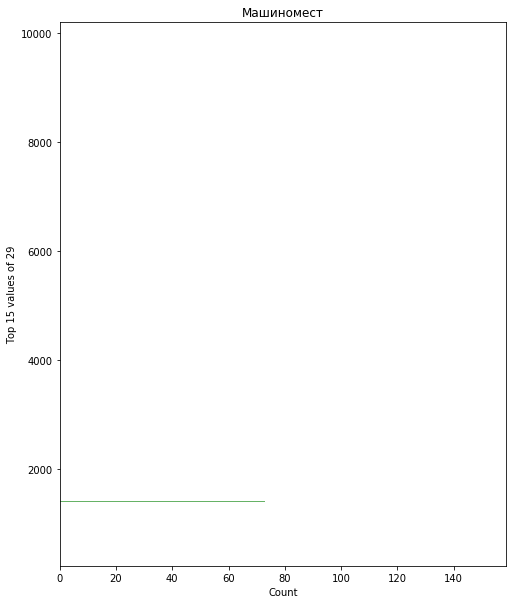

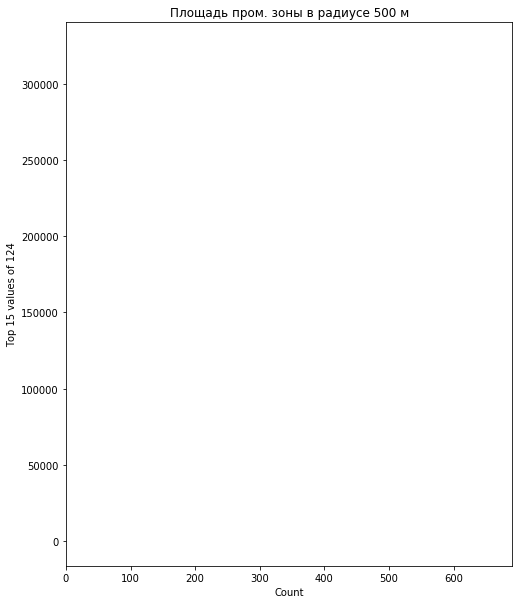

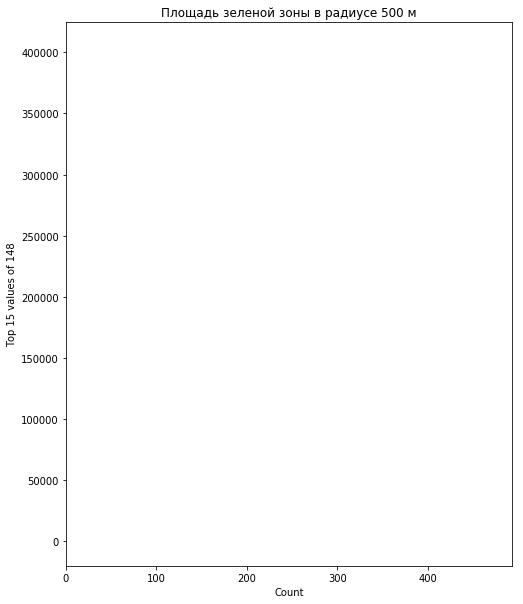

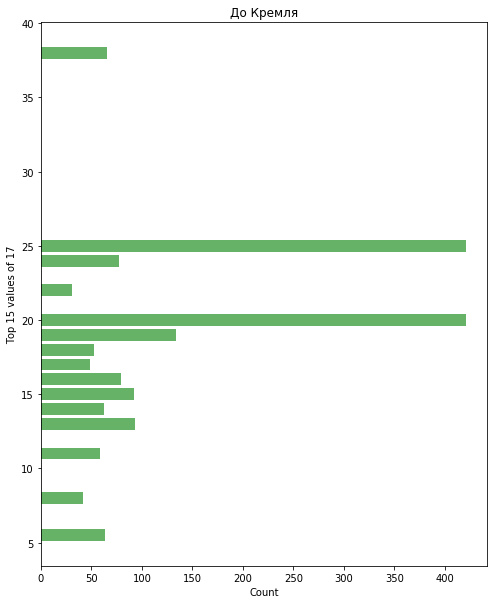

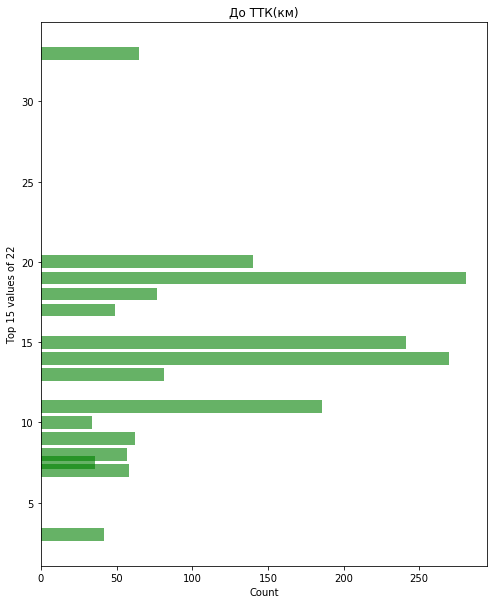

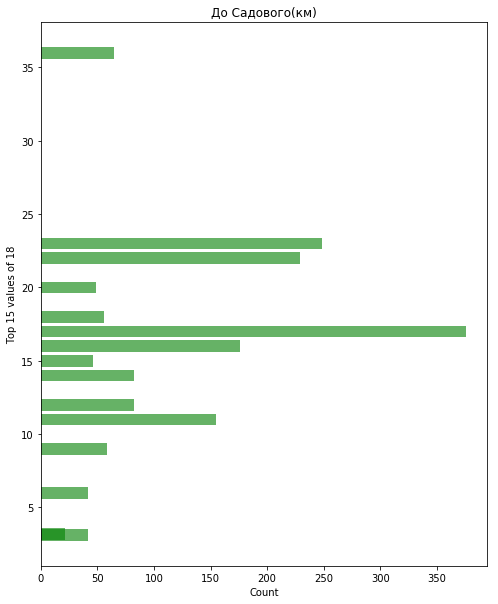

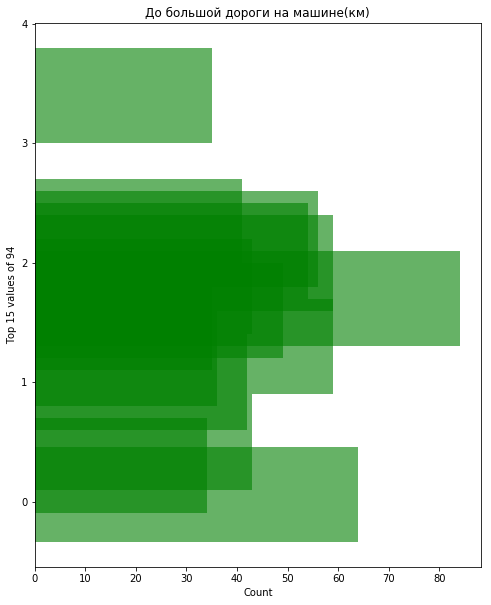

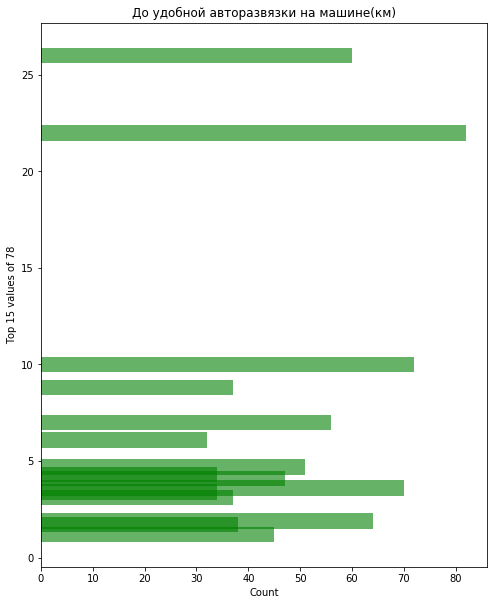

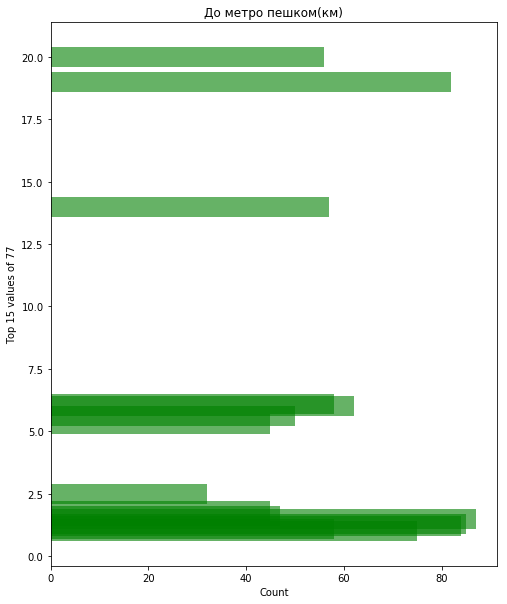

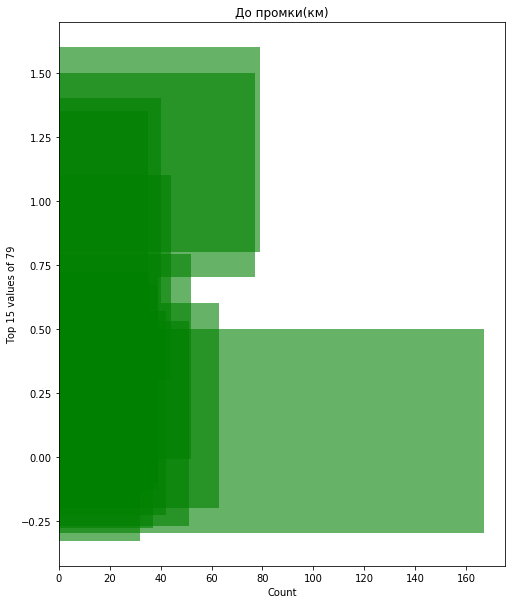

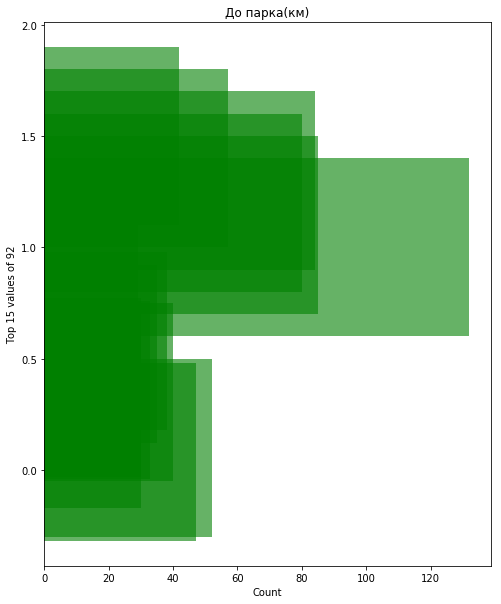

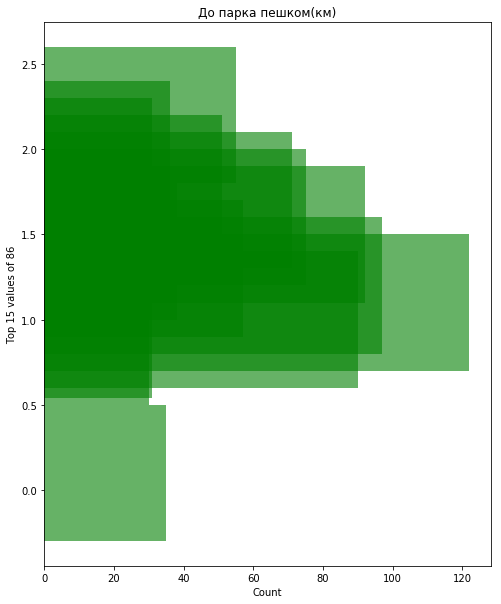

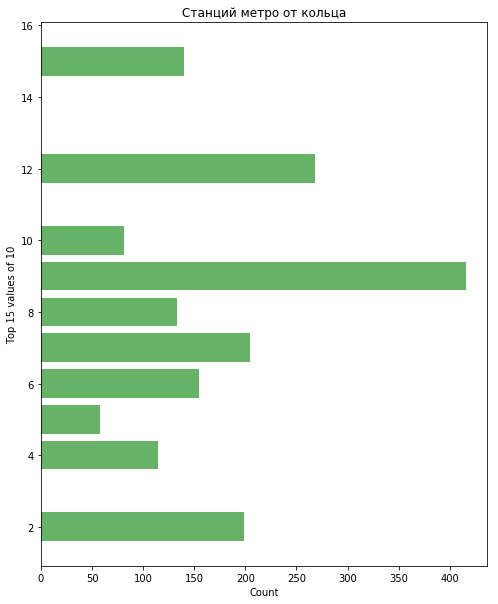

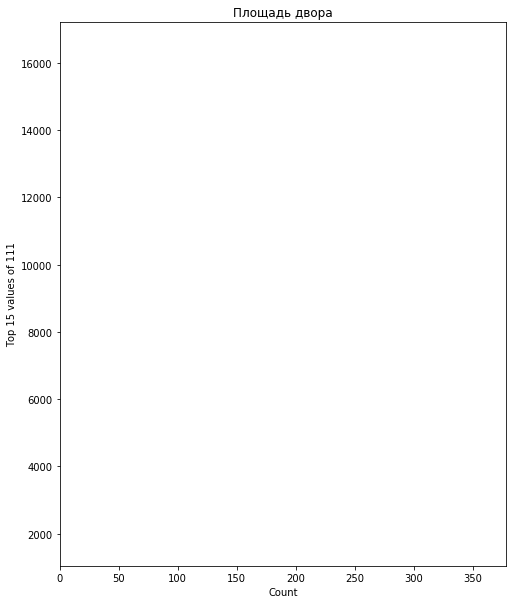

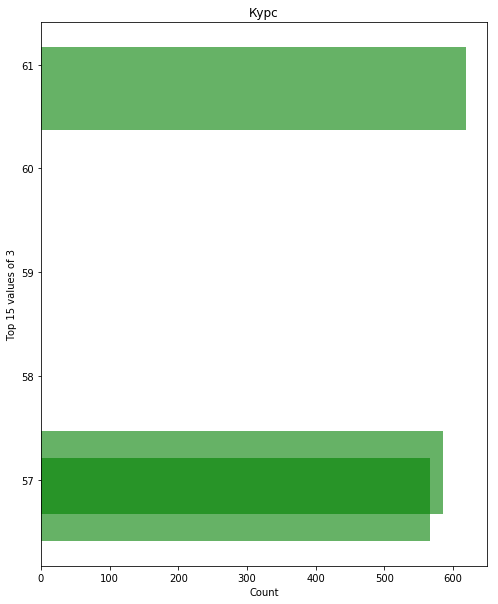

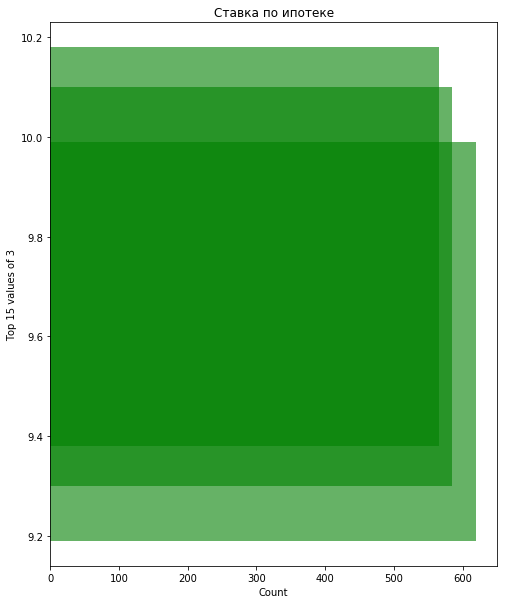

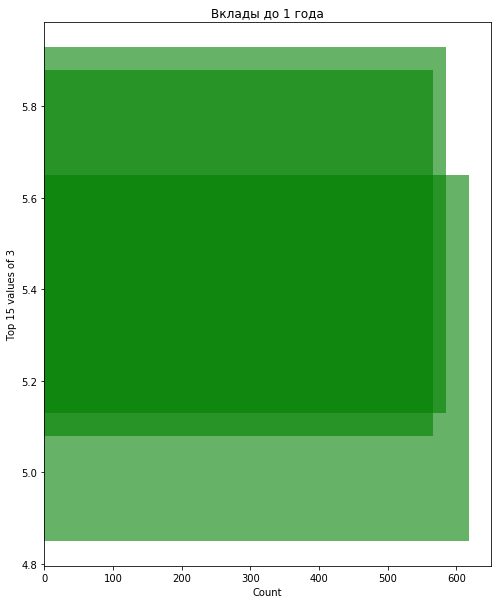

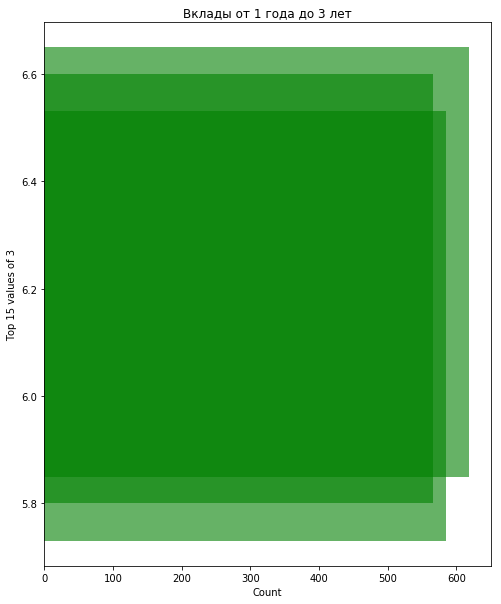

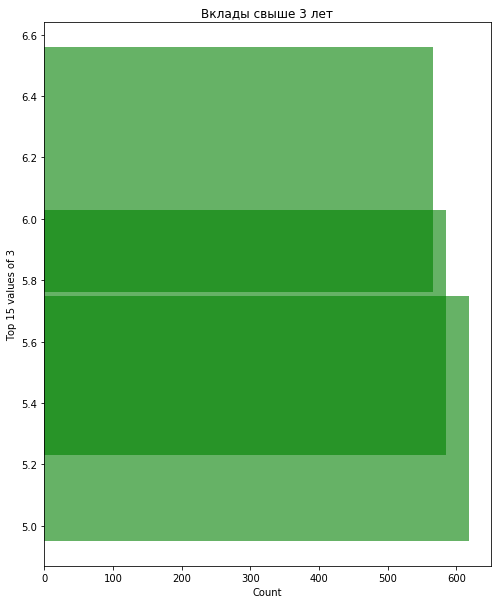

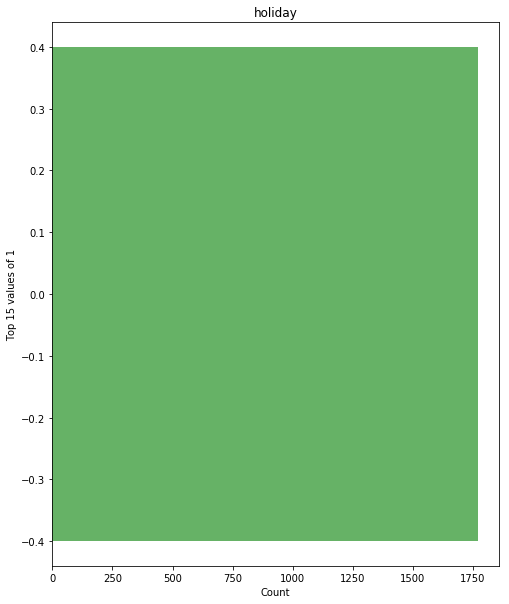

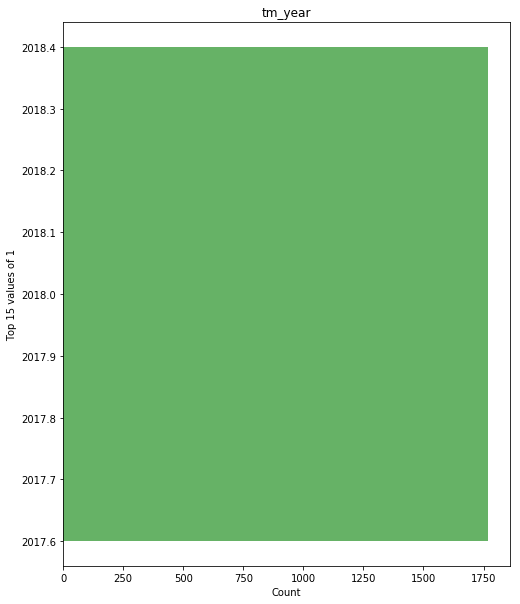

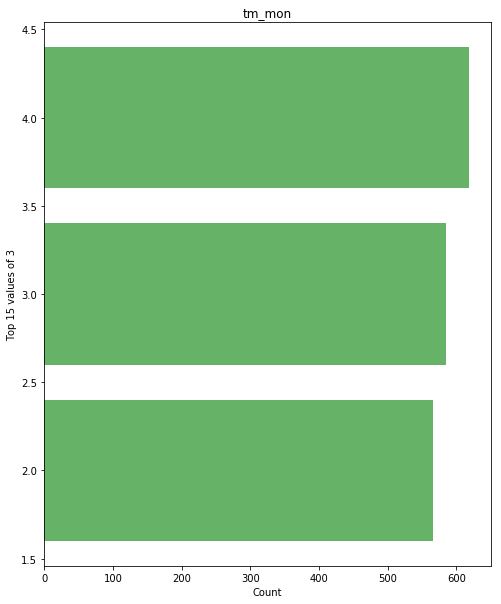

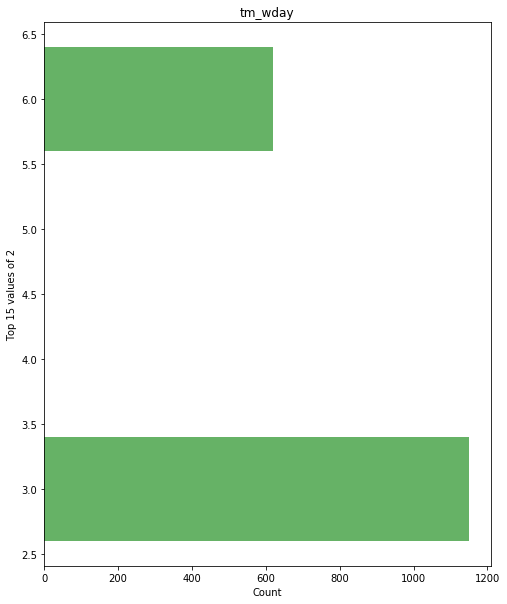

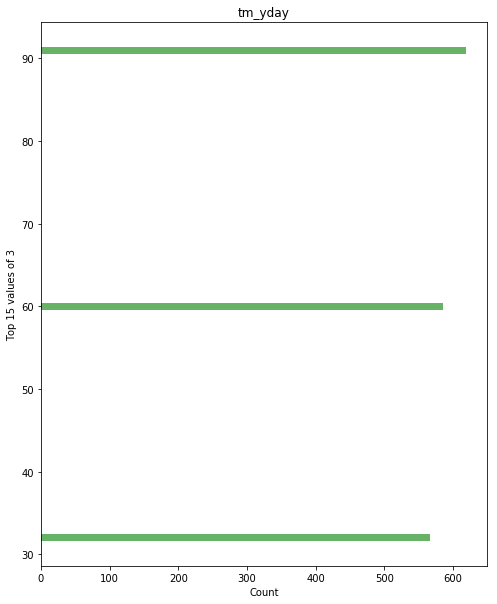

In [29]:
val_count(test, m_plot=True, name = 'test')

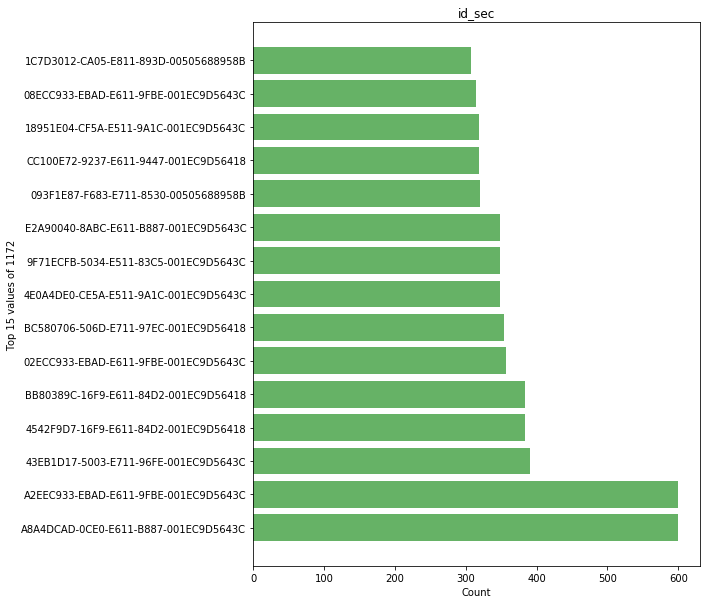

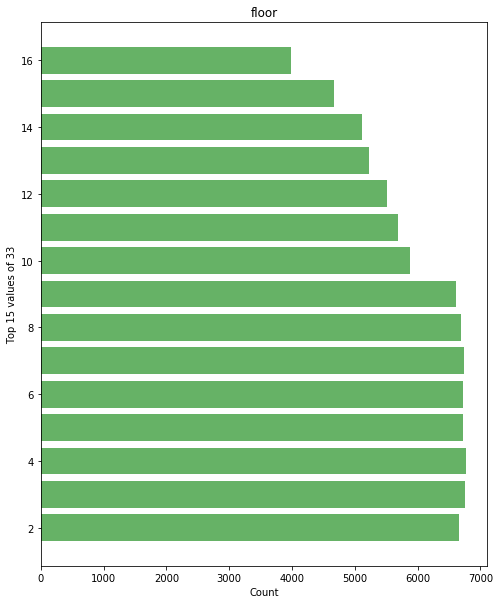

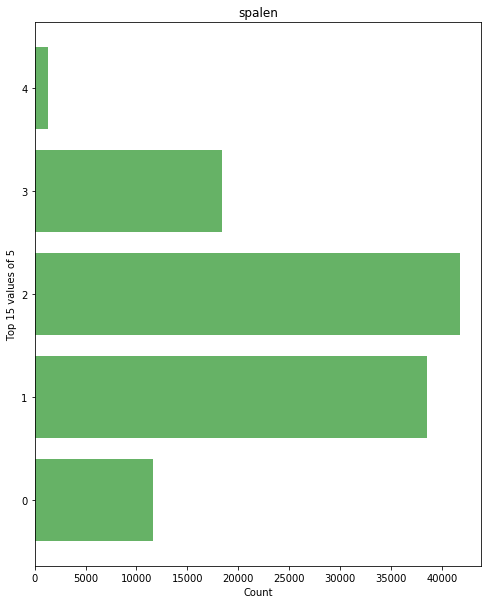

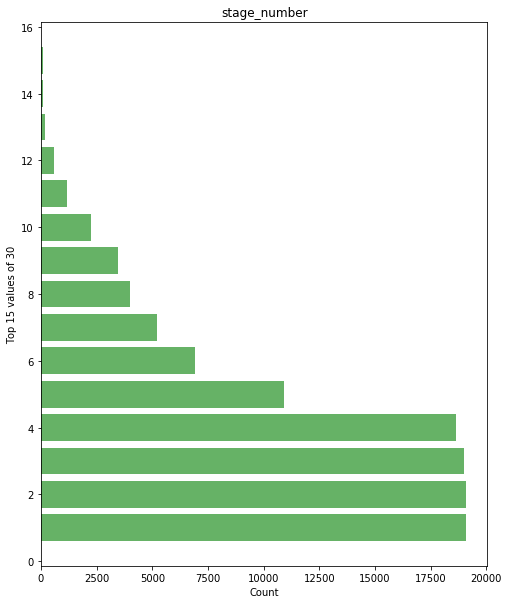

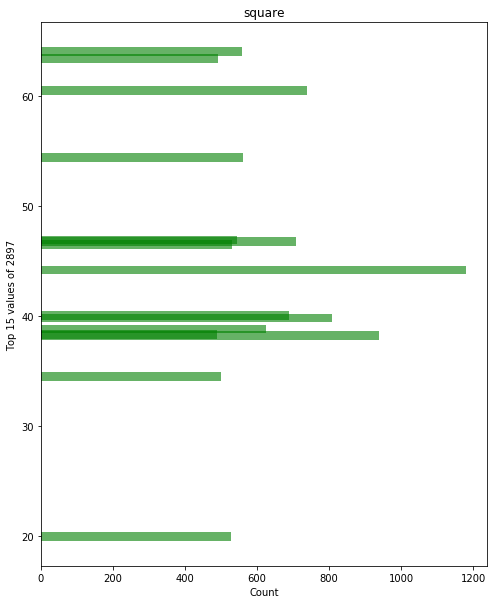

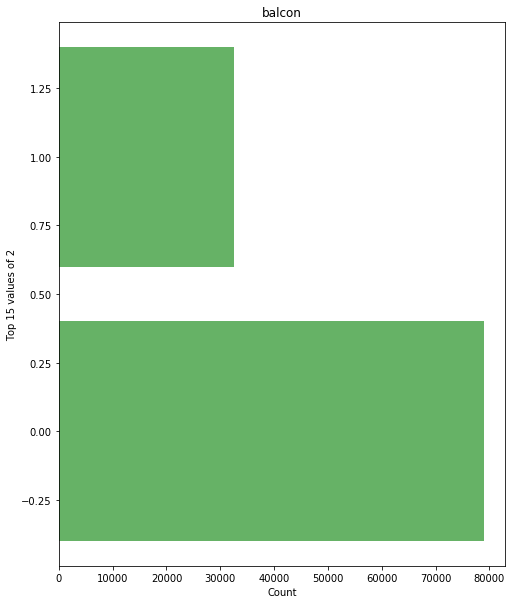

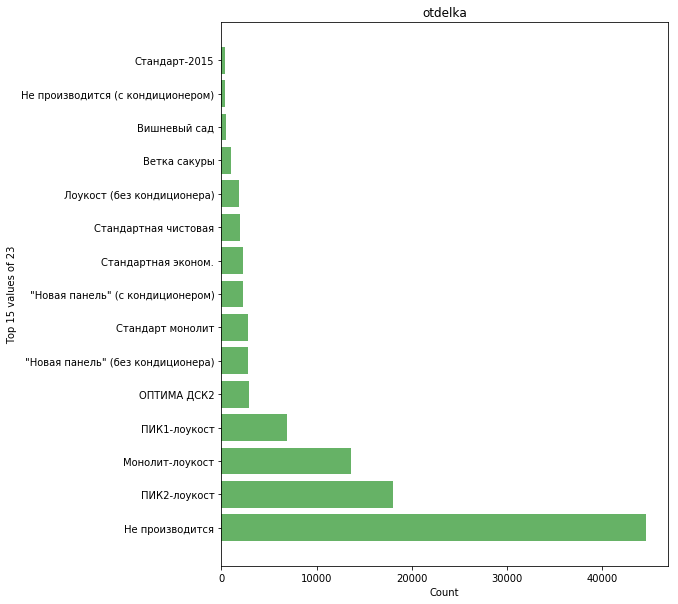

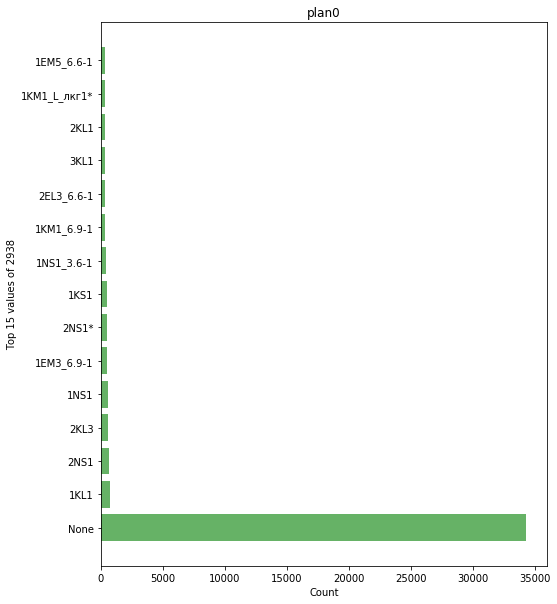

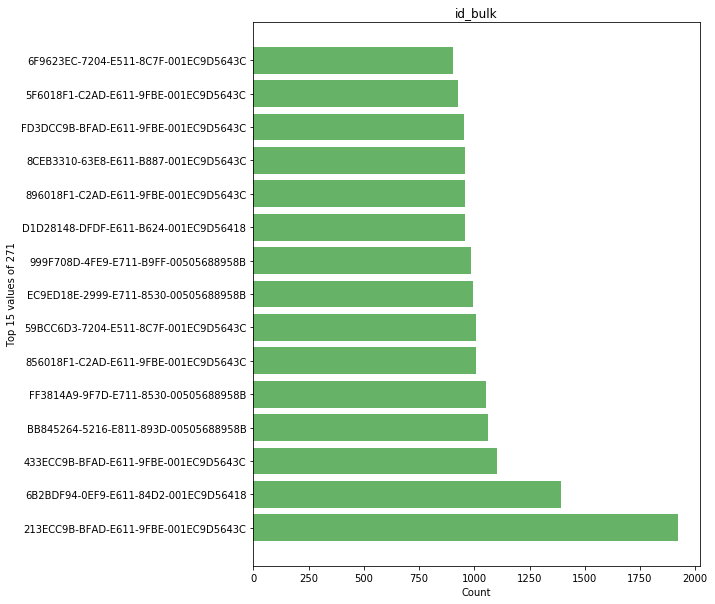

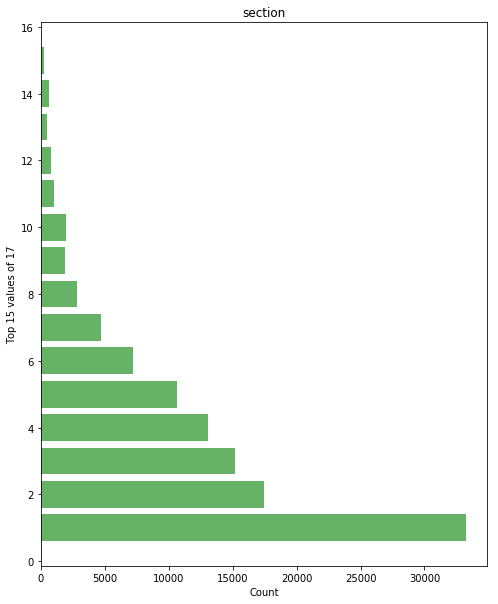

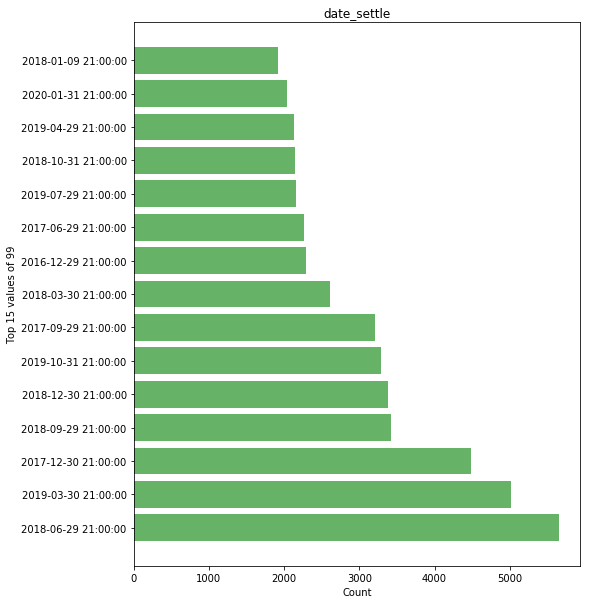

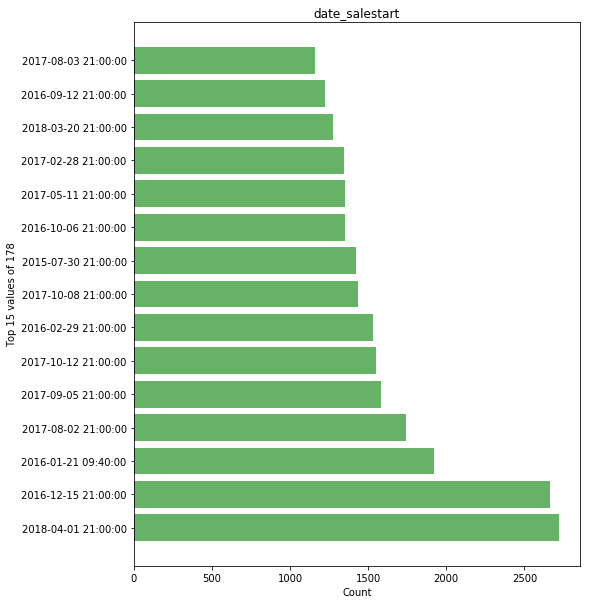

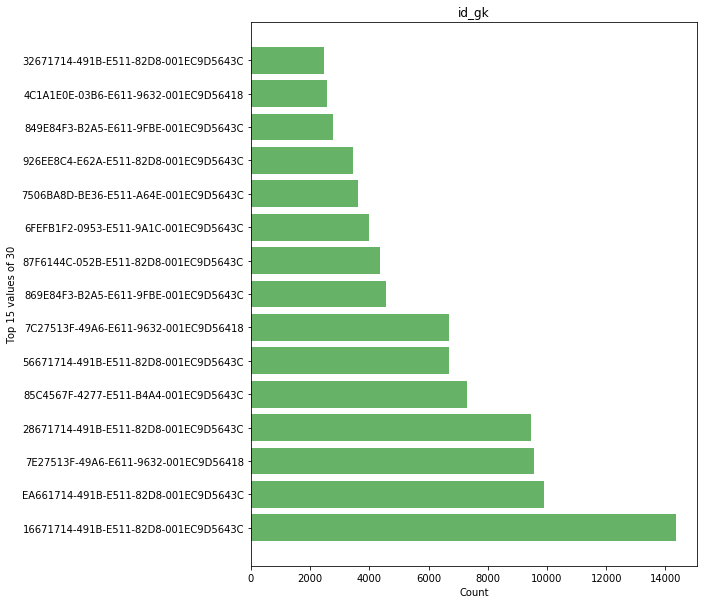

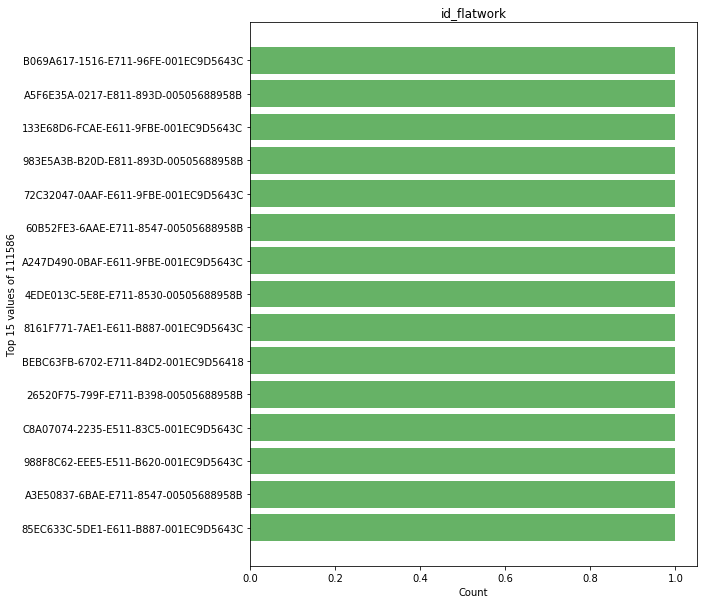

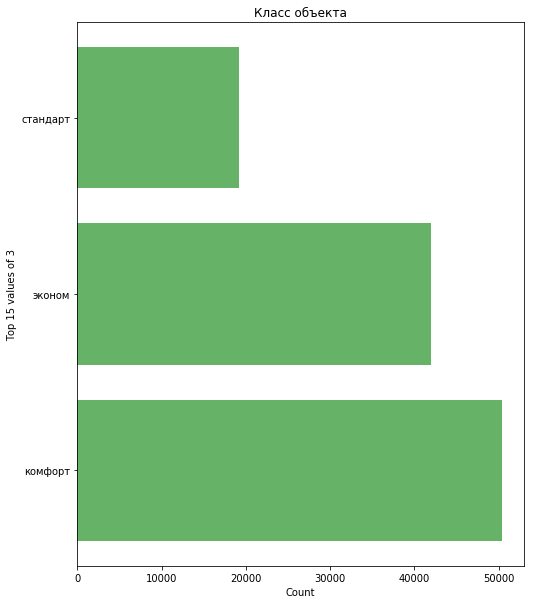

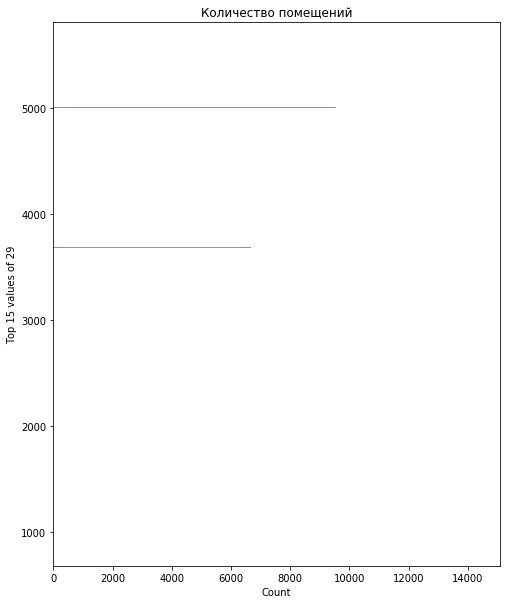

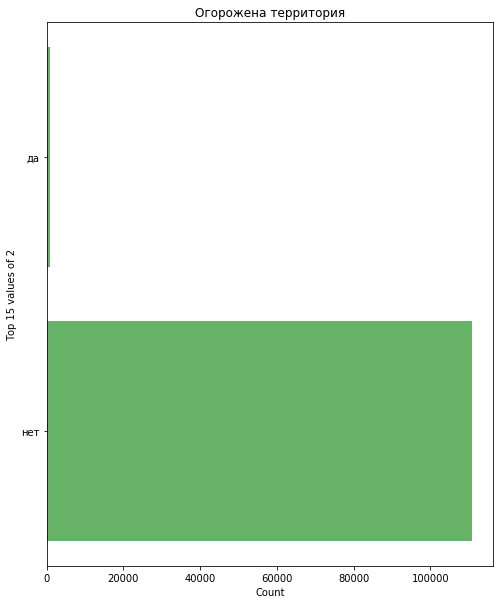

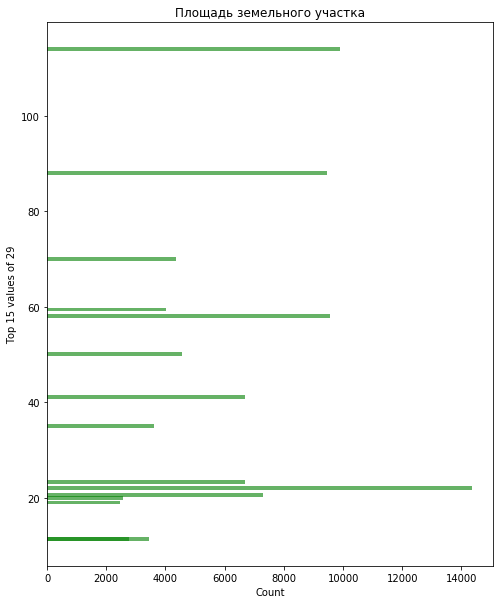

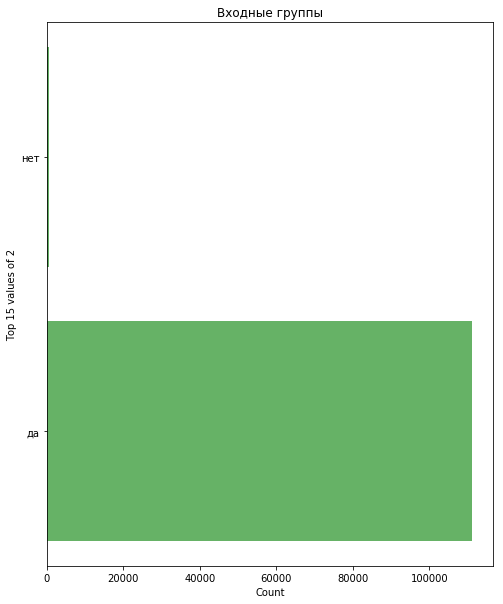

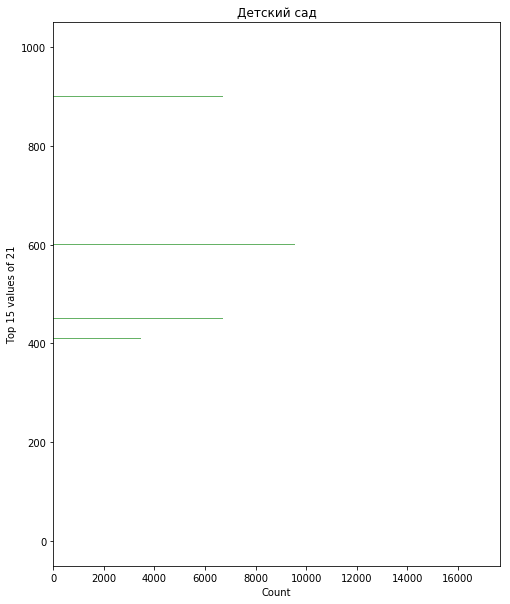

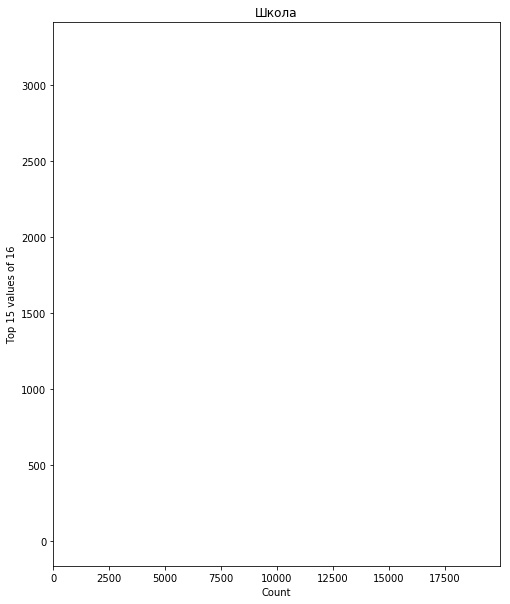

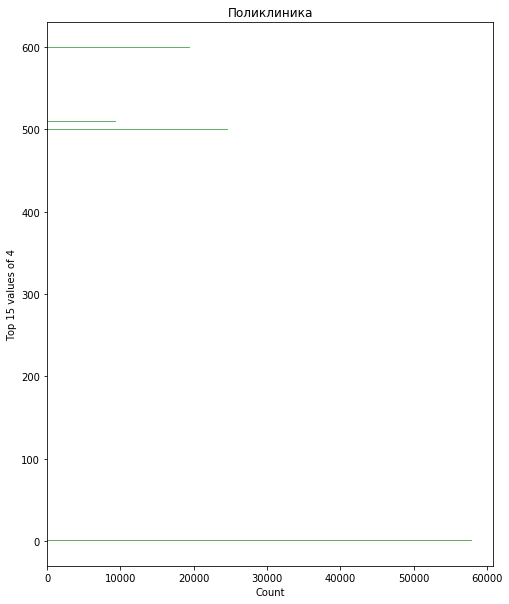

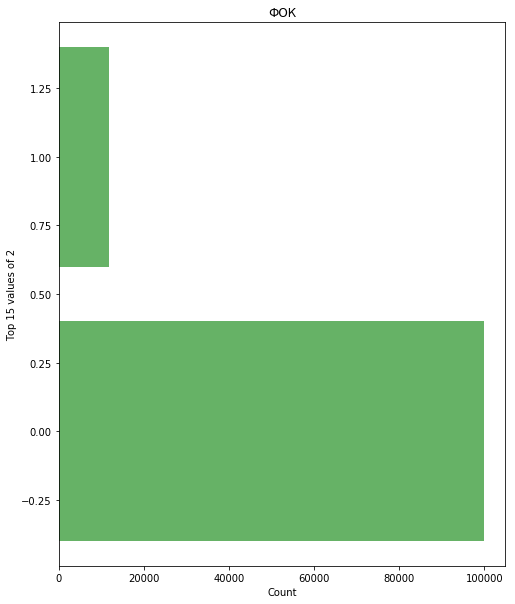

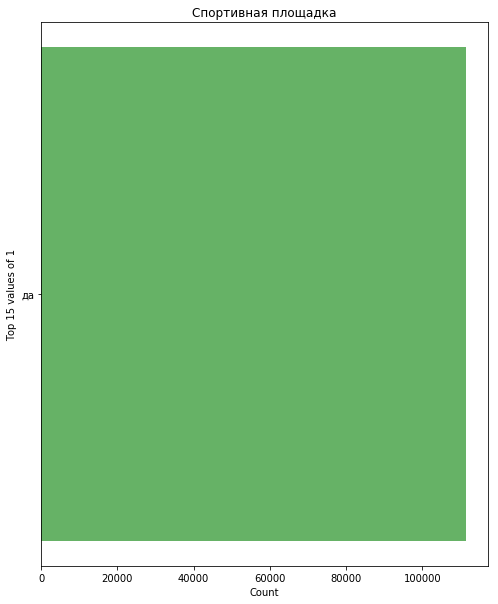

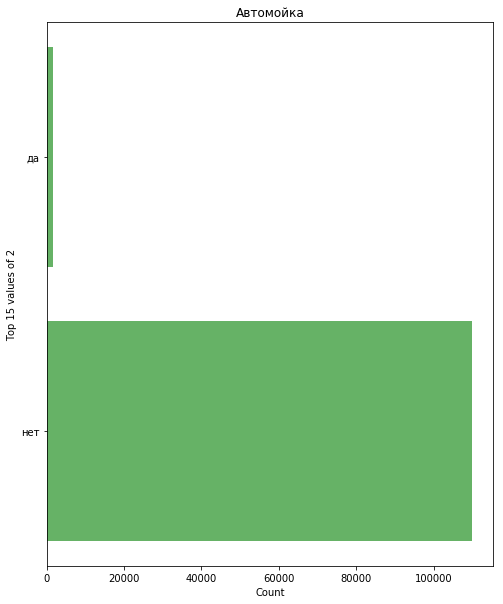

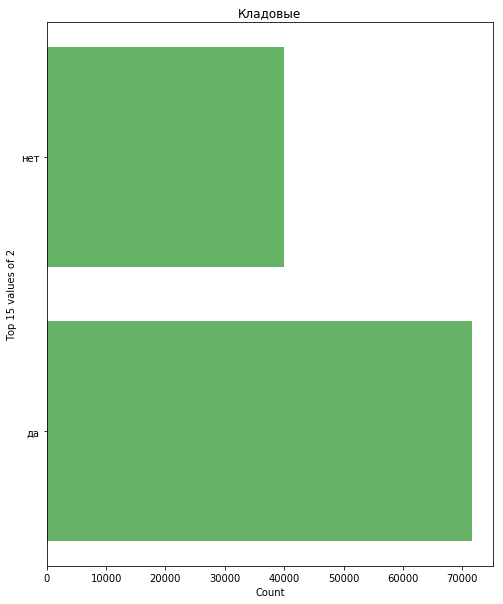

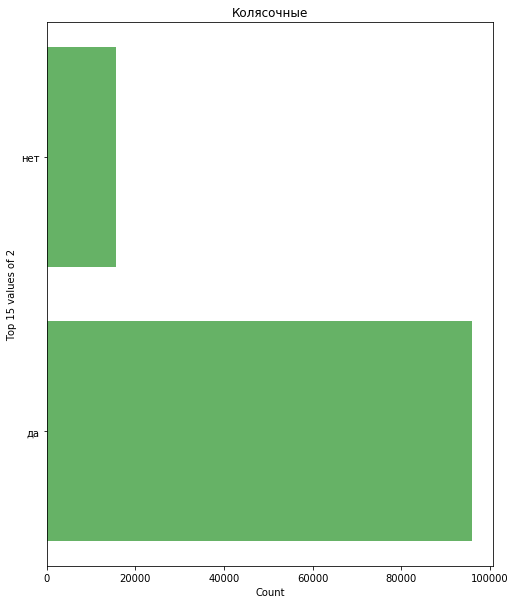

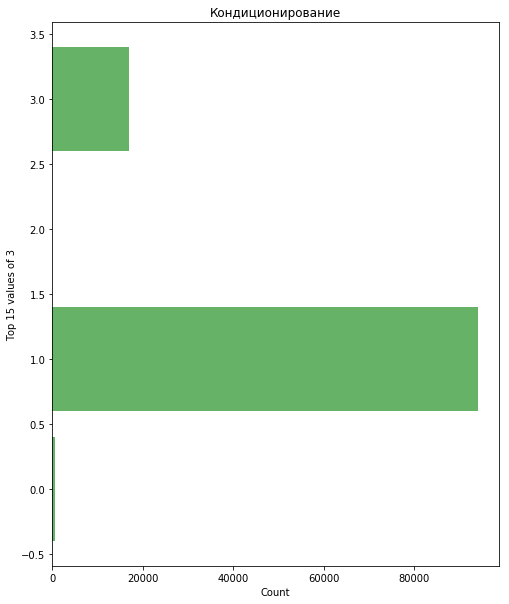

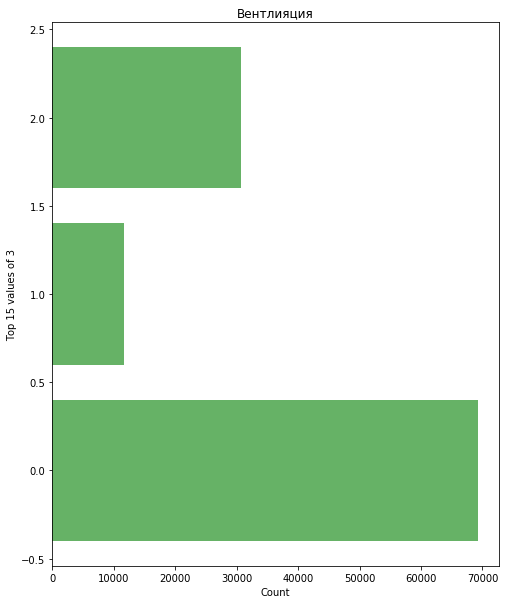

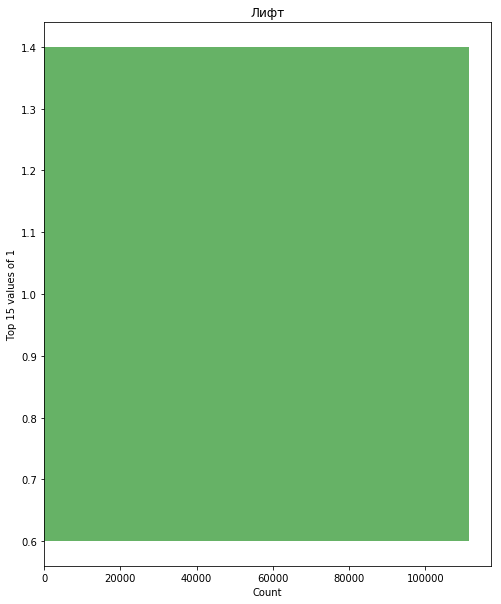

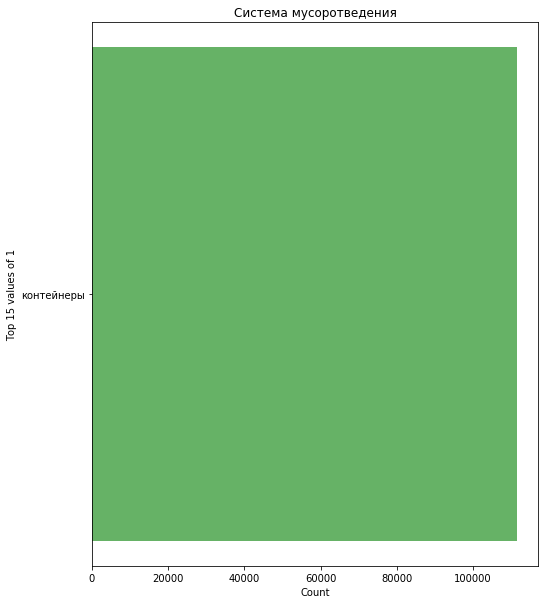

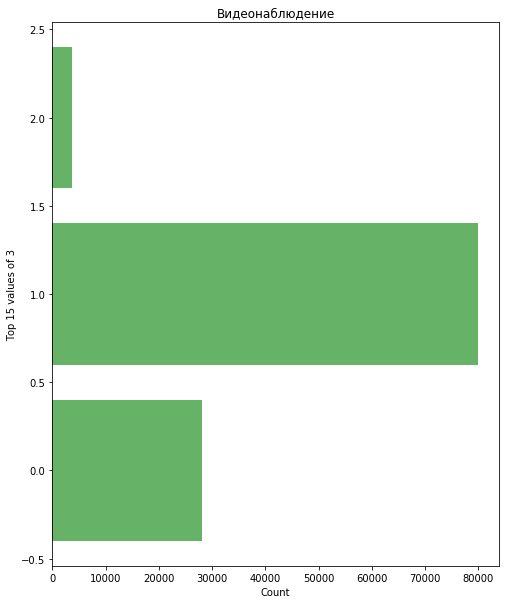

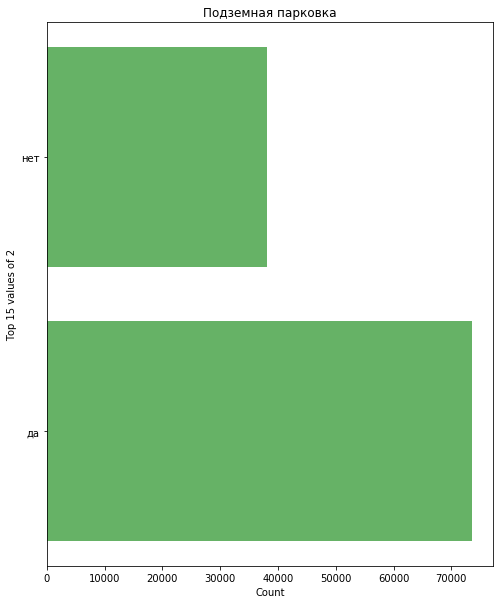

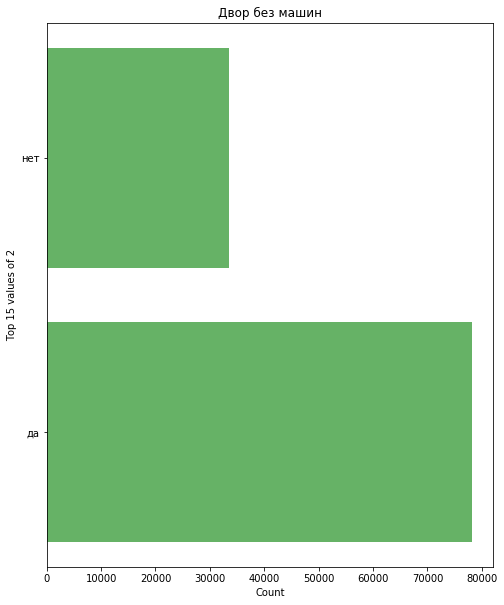

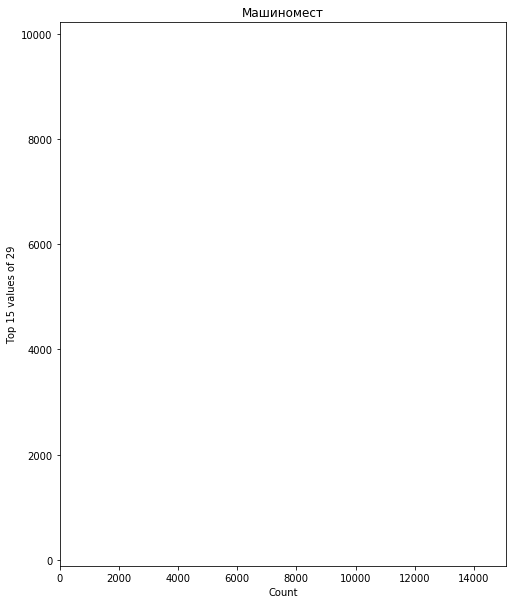

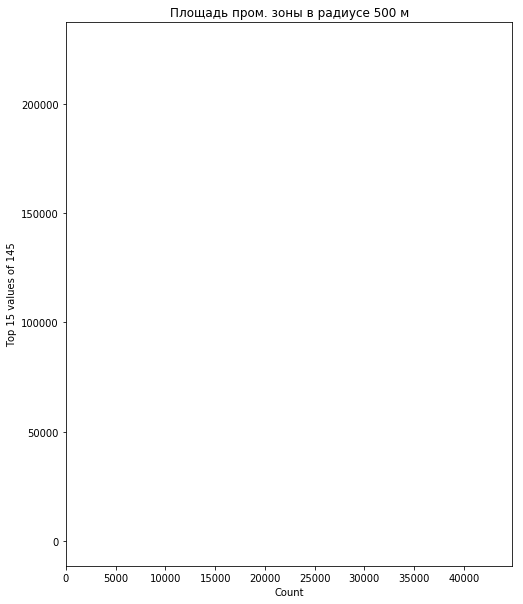

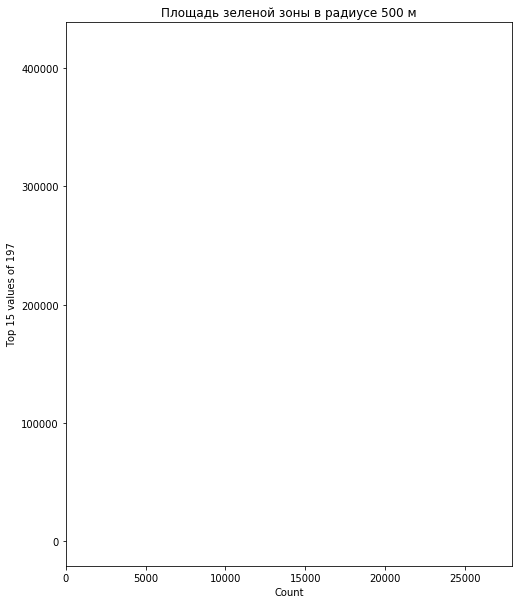

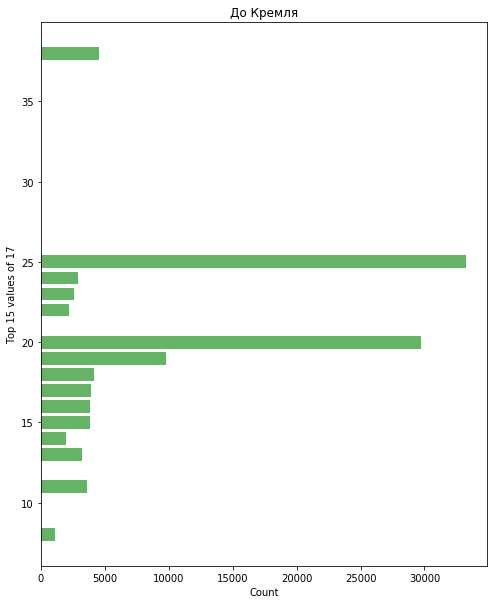

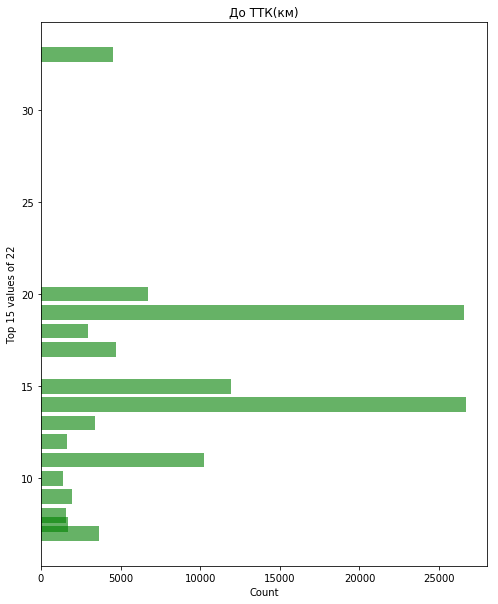

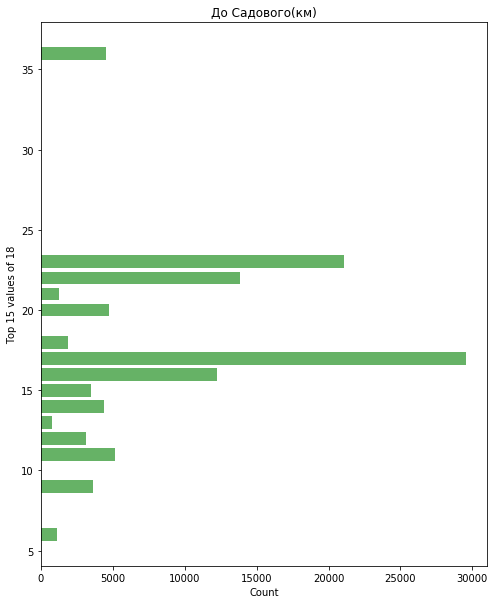

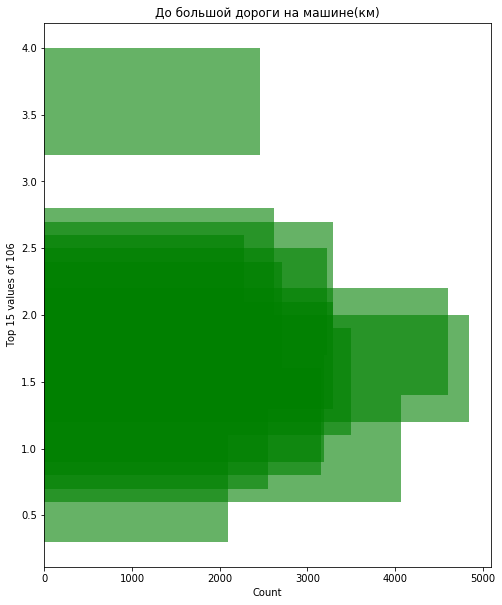

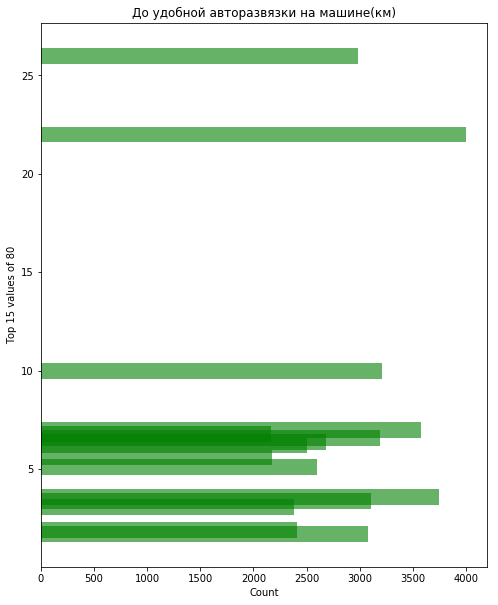

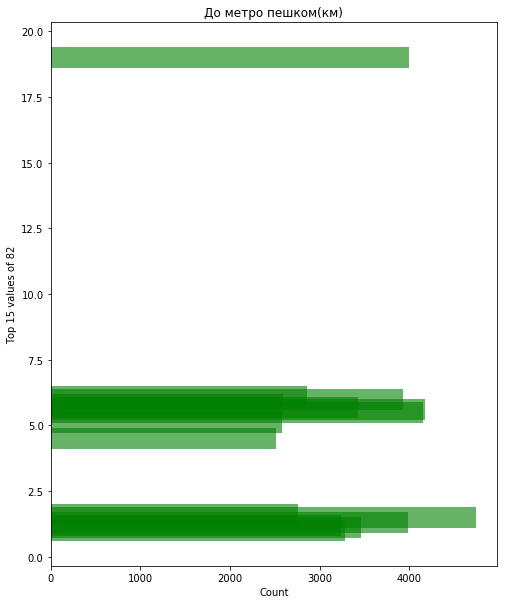

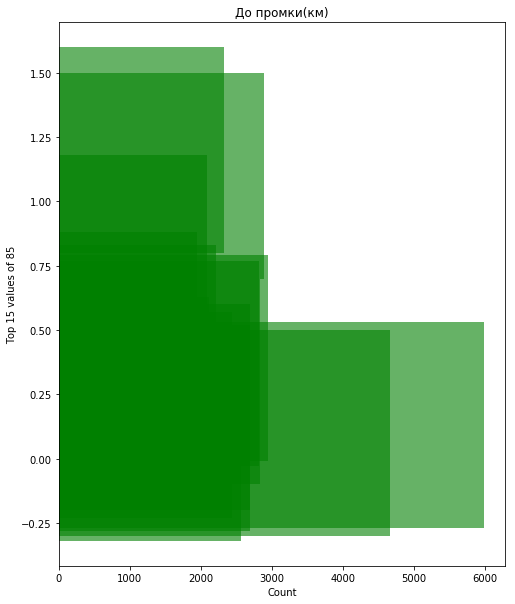

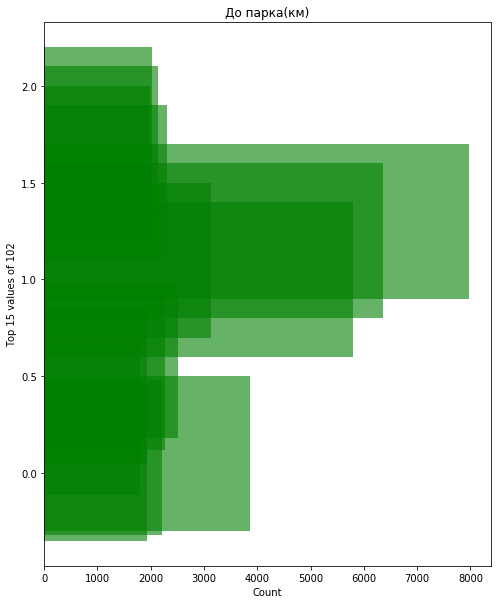

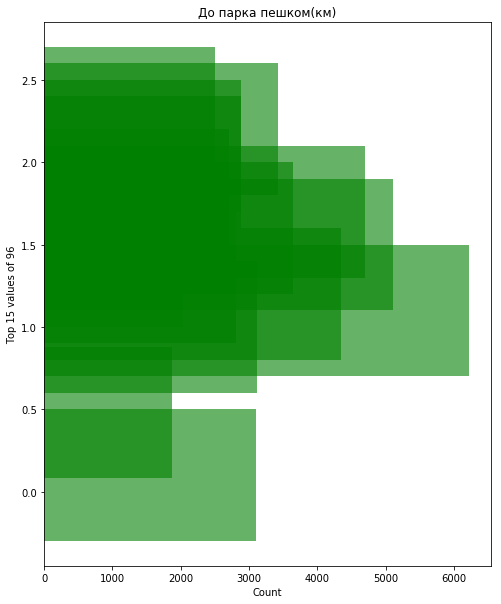

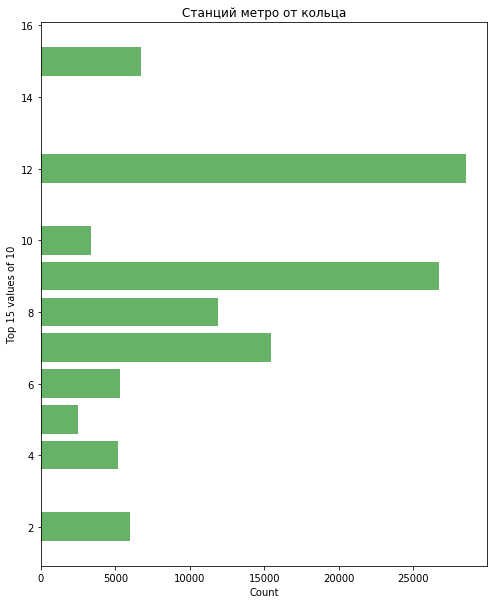

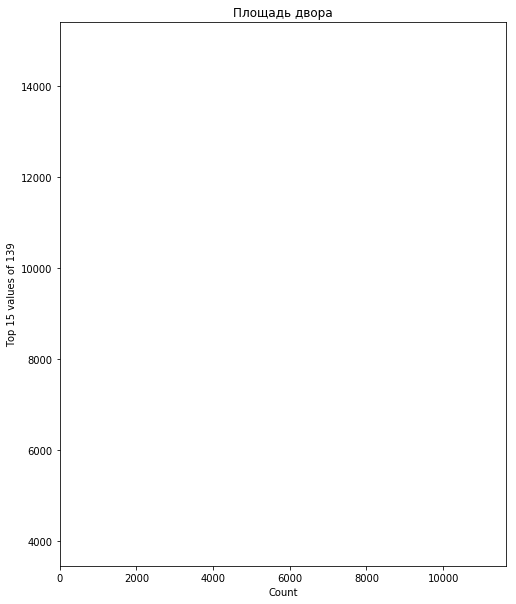

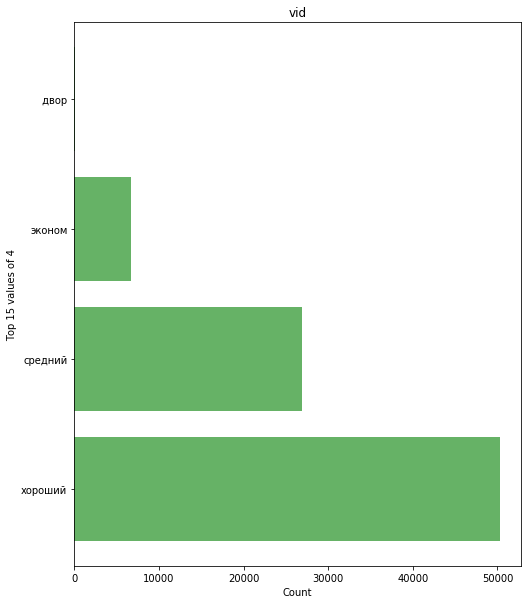

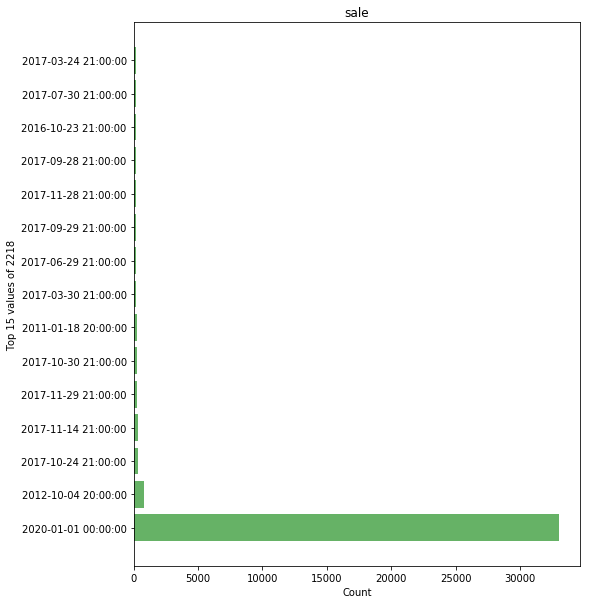

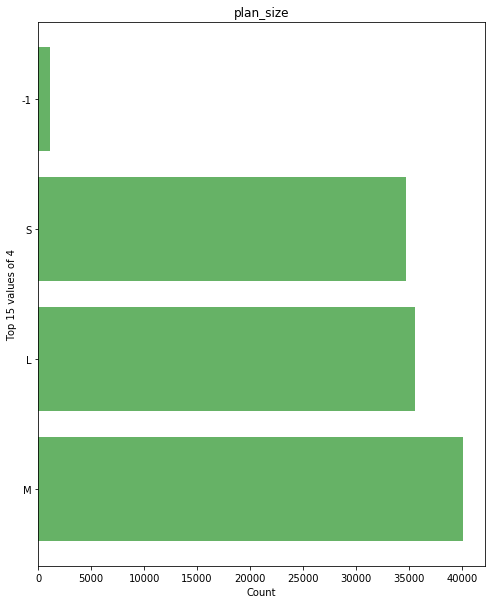

In [30]:
val_count(flat, m_plot=True, name = 'flat')

### Correlation

In [22]:
import seaborn as sns

In [23]:
def correlation_matrix(df):
    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(200, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

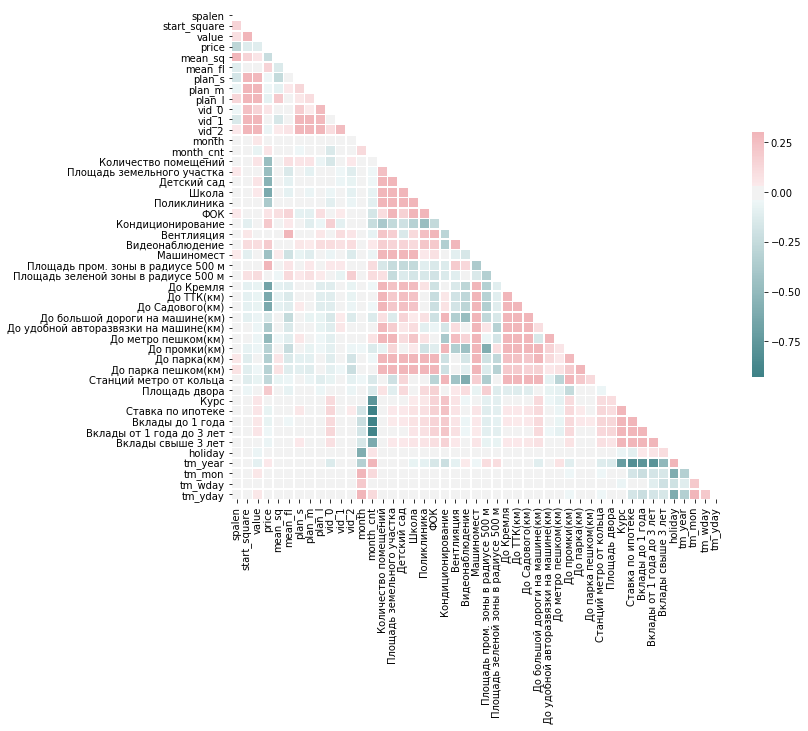

In [24]:
correlation_matrix(train)

### Gropby

In [ ]:
sales_df = df[[x for x in df.columns if 'Sales' in x] + ['Year_of_Release']]

### Find all num and cat features

In [25]:
cat_cols = [c for c in train.select_dtypes(include=['object']).columns if c not in dop_cat_cols]
num_cols = [c for c in train.select_dtypes(exclude=['object']).columns if c not in dop_cat_cols]
cat_cols = np.concatenate((dop_cat_cols, cat_cols))